# Pre-Work

### Install Modules

In [5]:
!pip install torch torchvision keras tensorflow[and-cuda]

  Using cached tensorflow-2.17.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 28.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 39.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

### Import Modules

In [1]:
# FC Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

# CNN Modules
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, RandomFlip, RandomRotation, Dropout
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

# Tools/Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import tensorflow as tf
import csv
import pandas as pd
from ast import literal_eval

2024-10-18 12:40:33.011695: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 12:40:33.033278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 12:40:33.400877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.is_available() # Gotta have that CUDA

True

In [3]:
tf.config.list_physical_devices('GPU') # Make sure keras like CUDA too

2024-10-16 11:12:47.355937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-16 11:12:47.409306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-16 11:12:47.409331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Set Random Seeds

In [3]:
torch.manual_seed(42)
keras.utils.set_random_seed(42)
np.random.seed(42)
random.seed(42)

# Model Training

## Part 1

### PyTorch FC ANN MNIST Implementation.

### Load Dataset

In [88]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation((-45,45))
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

/home/mist861/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [89]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

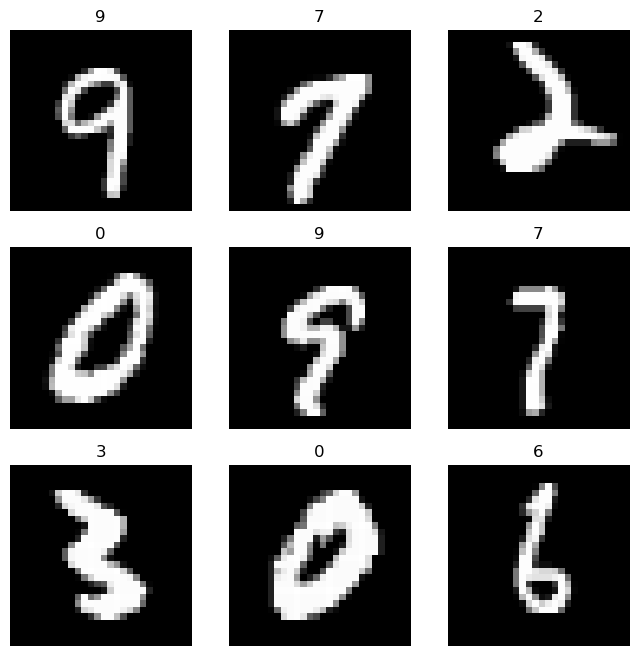

In [90]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Define the Model

In [91]:
#Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self, inputs, neurons, dropout, activation): #this initializes the structure of the network
    #def __init__(self): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(inputs, neurons[0]) ## First fully connected linear layer, 28*28 input features and 32 outputs
        for layer in range(2,len(neurons)): # Create the remaining fully connected layers, based on the given size of the outputs
            setattr(self, f'fc{layer}', nn.Linear(neurons[layer-2], neurons[layer-1])) # Of course, the input is the size of the previous output
            if (dropout == True) and (layer % 2 == 0): # If the dropout flag is set, add a dropout layer every 2 layers
                self.dropout = torch.nn.Dropout(0.2)
        setattr(self, f'fc{len(neurons)}', nn.Linear(neurons[len(neurons)-2], neurons[len(neurons)-1])) ## 10 output features because MNIST has 10 target classes
        self.size = len(neurons)
        self.activation = activation # Define the array of activation functions
    
    def forward(self, train_data): #this modifies the elements of the intial structure defined above
        train_data = train_data.view(-1, 28 * 28) #the array is sent in as a vector
        for layer in range(1,self.size):
            train_data = getattr(torch, f'{self.activation[layer-1]}')(getattr(self, f'fc{layer}')(train_data)) # Set the activation functions for each layer, except the output layer
        train_data = getattr(self, f'fc{self.size}')(train_data) # No modifications to the activation of the output layer, that's handled by the optimizer
        return train_data

    def fit(self, train_loader, optimizer, loss_function, learning_rate, weight_decay, batch_size, epochs): # Aside from the tensor changes, this was left alone
        criterion = getattr(nn, f'{loss_function}')()
        optimizer = getattr(optim, f'{optimizer}')(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device) # These both have to be cast to GPU tensors or it implodes
                labels = torch.Tensor(labels).to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % batch_size == (batch_size - 1):  # print every 100 mini-batches
                    print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                    running_loss = 0.0

    def score(self, test_data): # Like the above method, no changes except to the GPU tensors
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_data:
                images, labels = data
                images = torch.Tensor(images).to(device) # These.  Still have to be cast to GPU
                labels = torch.Tensor(labels).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        score = correct / total
        print(f'Accuracy on test set: {score}%')
        return score

In [34]:
# Testing the above with a random model

model = MLP((28*28), [30, 10, 10], True, ['sigmoid', 'relu'])
model.to(device)
model.fit(train_loader, 'SGD', 'CrossEntropyLoss', 0.002, 0, 100, 3)
#print(model)

Epoch 1, Batch 100, Loss: 2.320899908542633
Epoch 1, Batch 200, Loss: 2.31400821685791
Epoch 1, Batch 300, Loss: 2.303220727443695
Epoch 1, Batch 400, Loss: 2.302109658718109
Epoch 1, Batch 500, Loss: 2.298563554286957
Epoch 1, Batch 600, Loss: 2.295964391231537
Epoch 1, Batch 700, Loss: 2.287771234512329
Epoch 1, Batch 800, Loss: 2.2840355372428895
Epoch 1, Batch 900, Loss: 2.2825369954109194
Epoch 2, Batch 100, Loss: 2.275078468322754
Epoch 2, Batch 200, Loss: 2.2705150699615477
Epoch 2, Batch 300, Loss: 2.2652318406105043
Epoch 2, Batch 400, Loss: 2.2631150770187376
Epoch 2, Batch 500, Loss: 2.259621148109436
Epoch 2, Batch 600, Loss: 2.253930525779724
Epoch 2, Batch 700, Loss: 2.248571267127991
Epoch 2, Batch 800, Loss: 2.2497659659385683
Epoch 2, Batch 900, Loss: 2.2432373929023743
Epoch 3, Batch 100, Loss: 2.227466549873352
Epoch 3, Batch 200, Loss: 2.2226767921447754
Epoch 3, Batch 300, Loss: 2.2189650440216067
Epoch 3, Batch 400, Loss: 2.215651500225067
Epoch 3, Batch 500, Loss

In [35]:
score = model.score(test_loader)

Accuracy on test set: 0.2957%


### Define Hyperparameters

In [11]:
# Define the range of parameters for the grid search
parameters = {
    'inputs': 28*28,
    'number_of_layers': [1, 2, 3, 4],
    'outputs': 10,
    'neurons_per_layer': [10, 20, 30, 40, 50],
    'dropout_layers': [False, True],
    'activation_functions': ['relu', 'tanh', 'sigmoid'],
    'optimizers': ['Adam', 'SGD'],
    'learning_rates': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'weight_decays': [0.01, 0.03, 0.1, 0.3, 1],
    'loss_functions': ['CrossEntropyLoss'],
    'batches': [100,200,300],
    'epochs': [25] # This is going to take so long that I decided to keep it short
}

results = {}
best_parameters = {}
worst_parameters = {}
for parameter in parameters:
    results[parameter] = []
    best_parameters[parameter] = None
    worst_parameters[parameter] = None

results['score'] = []
best_parameters['score'] = -1
worst_parameters['score'] = 1
combination = 0
local_layers = {'neurons':[],'activations':[]}

### Train the Model

In [13]:
# Original Greedy Brute Force grid search that was infeasible because it would calculate ~108,000 different combination and take ~75 days, even on CUDA
'''
for number_of_layers in parameters['number_of_layers']:
    for neurons_per_layer in parameters['neurons_per_layer']:
        for dropout_layer in parameters['dropout_layers']:
            for activation_function in parameters['activation_functions']:
                for optimizer in parameters['optimizers']:
                    for learning_rate in parameters['learning_rates']:
                        for weight_decay in parameters['weight_decays']:
                            for loss_function in parameters['loss_functions']:
                                for batch in parameters['batches']:
                                    for epochs in parameters['epochs']:
                                        
                                        neurons = []
                                        if number_of_layers < 3:
                                            neurons.append(neurons_per_layer)
                                        else:
                                            neurons += local_layers['neurons']
                                            neurons.append(neurons_per_layer)
                                        neurons.append(parameters['outputs'])
    
                                        activations = []
                                        if number_of_layers < 3:
                                            activations.append(activation_function)
                                        else:
                                            activations += local_layers['activation']
                                            neurons.append(activation_function)
    
                                        print(f"Fitting for combination {combination}")
                                        
                                        model = MLP((parameters['inputs']), neurons, dropout_layer, activations, train_loader)
                                        model.to(device)
                                        model.fit(optimizer, loss_function, learning_rate, weight_decay, epochs)
                                        
                                        # Evaluate the model on the validation data
                                        score = model.score(test_loader)
    
                                        results['number_of_layers'].append(number_of_layers)
                                        results['neurons_per_layer'].append(neurons_per_layer)
                                        results['dropout_layers'].append(dropout_layer)
                                        results['activation_functions'].append(activation_function)
                                        results['optimizers'].append(optimizer)
                                        results['learning_rates'].append(learning_rate)
                                        results['weight_decays'].append(weight_decay)
                                        results['loss_functions'].append(loss_function)
                                        results['batches'].append(batch)
                                        results['epochs'].append(epochs)
                                        results['inputs'].append(parameters['inputs'])
                                        results['outputs'].append(parameters['outputs'])
                                        results['score'].append(score)
                                        
                                        # If the current score is better than the best score, update the best score and best parameters
                                        if score > best_parameters['score']:
                                            best_score = score
                                            for parameter in results:
                                                best_parameters[parameter] = results[parameter][combination]
                                            if len(local_layers['neurons']) < number_of_layers - 1:
                                                print(f"neurons {neurons_per_layer}")
                                                print(f"activation {activation_function}")
                                                local_layers['neurons'].append(neurons_per_layer)
                                                local_layers['activation'].append(activation_function)
                                            else:
                                                local_layers['neurons'][number_of_layers-2] = neurons_per_layer
                                                local_layers['activation'][number_of_layers-2] = activation_function
                                        elif score < worst_parameters['score']:
                                            worst_score = score
                                            for parameter in results:
                                                worst_parameters[parameter] = results[parameter][combination]
                                        
                                        combination += 1
'''

# Much more reasonable Randomized Greedy grid search that only brute forces the number of layers, neurons per layer, and optimization functions,
# which calculates ~40 different combination (~3.5 hours). All other parameters are chosen randomly during each iteration
for number_of_layers in parameters['number_of_layers']:
    for neurons_per_layer in parameters['neurons_per_layer']:
        for optimizer in parameters['optimizers']:

            # Randomly select the other hyperparameters
            dropout_layer = random.choice(parameters['dropout_layers'])
            activation_function = random.choice(parameters['activation_functions'])
            learning_rate = random.choice(parameters['learning_rates'])
            weight_decay = random.choice(parameters['weight_decays'])
            loss_function = random.choice(parameters['loss_functions']) # I'm aware that there is only a single loss function, I'm just treating it the same as everything else
            batch = random.choice(parameters['batches'])
            epochs = random.choice(parameters['epochs'])
            
            # Create the network architecture                       
            neurons = [] # Neurons array to store the neurons_per_layer
            activations = [] # Activations array to store the activations per layer
            if len(local_layers['neurons']) < number_of_layers: # If there aren't yet enough "best performing" neurons for the layer it's on, toss something in it
                local_layers['neurons'].append(neurons_per_layer)
                local_layers['activations'].append(activation_function)
            for layer in range(0,number_of_layers-1): # Add in the "best" results from the previous layers, if any
                neurons.append(local_layers['neurons'][layer])
                activations.append(local_layers['activations'][layer])
            neurons.append(neurons_per_layer) # Add the current number of neurons being tested for this layer
            activations.append(activation_function) # Add the current (random) activation function being tested for this layer
            neurons.append(parameters['outputs']) # For the final output layer, meaning we always have number_of_layers + 1 total layers
            # PLEASE NOTE: the optimizer handles the softmax function on the output, so no softmax activation is added, meaning
            # the activations array will always be one shorter than the neurons array
    
            print(f"Fitting for combination {combination}")

            # Save the current set of hyperparameters into results
            results['number_of_layers'].append(number_of_layers)
            results['neurons_per_layer'].append(neurons)
            results['dropout_layers'].append(dropout_layer)
            results['activation_functions'].append(activations)
            results['optimizers'].append(optimizer)
            results['learning_rates'].append(learning_rate)
            results['weight_decays'].append(weight_decay)
            results['loss_functions'].append(loss_function)
            results['batches'].append(batch)
            results['epochs'].append(epochs)
            results['inputs'].append(parameters['inputs'])
            results['outputs'].append(parameters['outputs'])
            results['score'].append(0)

            for parameter in results:
                print(results[parameter][combination])

            # Define and fit the network
            model = MLP((parameters['inputs']), neurons, dropout_layer, activations)
            model.to(device)
            model.fit(train_loader, optimizer, loss_function, learning_rate, weight_decay, batch, epochs)
            
            # Evaluate the model on the validation data
            score = model.score(test_loader)
            results['score'][combination] = score
            
            # If the current score is better than the best score, update the best score, best parameters, and save the architecture into local_layers
            # This is what makes the algorithm "greedy" instead of brute force
            if score > best_parameters['score']:
                for parameter in results:
                    best_parameters[parameter] = results[parameter][combination]
                local_layers['neurons'] = neurons
                local_layers['activations'] = activations
            elif score < worst_parameters['score']:
                for parameter in results:
                    worst_parameters[parameter] = results[parameter][combination]
            
            combination += 1

print('Best parameters:', best_parameters)

Fitting for combination 0
784
1
10
[10, 10]
False
['sigmoid']
Adam
0.3
1
CrossEntropyLoss
300
25
0
Epoch 1, Batch 300, Loss: 6.939032137393951
Epoch 1, Batch 600, Loss: 6.939589216709137
Epoch 1, Batch 900, Loss: 7.026755197048187
Epoch 2, Batch 300, Loss: 6.990331830978394
Epoch 2, Batch 600, Loss: 7.009798233509064
Epoch 2, Batch 900, Loss: 7.06328198671341
Epoch 3, Batch 300, Loss: 7.0206928944587705
Epoch 3, Batch 600, Loss: 7.04870913028717
Epoch 3, Batch 900, Loss: 7.049217858314514
Epoch 4, Batch 300, Loss: 7.024928114414215
Epoch 4, Batch 600, Loss: 7.073163459300995
Epoch 4, Batch 900, Loss: 7.054160330295563
Epoch 5, Batch 300, Loss: 7.02917270898819
Epoch 5, Batch 600, Loss: 7.048529734611511
Epoch 5, Batch 900, Loss: 7.0216766810417175
Epoch 6, Batch 300, Loss: 7.005801627635956
Epoch 6, Batch 600, Loss: 6.9944692850112915
Epoch 6, Batch 900, Loss: 6.999129559993744
Epoch 7, Batch 300, Loss: 6.985286393165588
Epoch 7, Batch 600, Loss: 7.00192095041275
Epoch 7, Batch 900, Lo

In [17]:
print(best_parameters) # THERE IS SOMETHING WRONG WITH HOW THIS IS BEING TRACKED AND I'M NOT ENTIRELY SURE WHAT
print(worst_parameters) # THIS ONE SEEMS PRETTY RIGHT THOUGH

{'inputs': 784, 'number_of_layers': 1, 'outputs': 10, 'neurons_per_layer': [30, 10, 10, 10], 'dropout_layers': False, 'activation_functions': ['tanh', 'sigmoid', 'relu'], 'optimizers': 'Adam', 'learning_rates': 0.001, 'weight_decays': 0.01, 'loss_functions': 'CrossEntropyLoss', 'batches': 100, 'epochs': 25, 'score': 0.9315}
{'inputs': 784, 'number_of_layers': 1, 'outputs': 10, 'neurons_per_layer': [20, 10], 'dropout_layers': False, 'activation_functions': ['sigmoid'], 'optimizers': 'Adam', 'learning_rates': 0.3, 'weight_decays': 1, 'loss_functions': 'CrossEntropyLoss', 'batches': 100, 'epochs': 25, 'score': 0.0892}


Please note that there is something...  WRONG with the above.  The score, 0.9315, is correct.  The greedy algorithm is also seemingly working correctly, which will be shown below.  Just the tracking of the best parameters is messed up.  The REAL best parameters are these:

784
1
10
[30, 10]
False
['tanh']
Adam
0.001
0.01
CrossEntropyLoss
100
25
0

I believe there is some defect in the results and parameter dicts caused by the mutability of arrays in python.  Somehow.  It seems to have only impacted the best results of each model, and only the arrays (neurons_per_layer and activation_functions). I figured this out after training all of these hundreds of models and I don't want to spend hours re-running all of these tests when the only thing "wrong" is the results dict. The results will be manually fixed before calculating any metrics down below

In [21]:
with open("mnist_without_augments.csv", "w", newline="") as file:
    writer = csv.DictWriter(file, results.keys())
    writer.writeheader()
    writer.writerow(results)

### Evaluate the Best Model

These are some results from a previous full run that had some iteration issues, but it shows us something interesting: 90% accuracy can be obtained with only a single hidden layer and an output layer, so 2 layers total:

print(best_parameters)

print(worst_parameters)

{'inputs': 784, 'number_of_layers': 2, 'outputs': 10, 'neurons_per_layer': [10, 10], 'dropout_layers': False, 'activation_functions': ['tanh'], 'optimizers': 'SGD', 'learning_rates': 0.003, 'weight_decays': 0.01, 'loss_functions': 'CrossEntropyLoss', 'batches': 100, 'epochs': 25, 'score': 0.9066}

{'inputs': 784, 'number_of_layers': 3, 'outputs': 10, 'neurons_per_layer': [10, 40, 10], 'dropout_layers': True, 'activation_functions': ['tanh', 'sigmoid'], 'optimizers': 'Adam', 'learning_rates': 0.1, 'weight_decays': 0.1, 'loss_functions': 'CrossEntropyLoss', 'batches': 300, 'epochs': 25, 'score': 0.0892}

In [18]:
# And here's the proof for the above

model = MLP((28*28), [10, 10], False, ['tanh'])
model.to(device)
model.fit(train_loader, 'SGD', 'CrossEntropyLoss', 0.003, 0.01, 100, 25)
score = model.score(test_loader)

Epoch 1, Batch 100, Loss: 2.1683448660373688
Epoch 1, Batch 200, Loss: 1.8907299280166625
Epoch 1, Batch 300, Loss: 1.7443784546852112
Epoch 1, Batch 400, Loss: 1.6490601587295532
Epoch 1, Batch 500, Loss: 1.5699206805229187
Epoch 1, Batch 600, Loss: 1.4962298274040222
Epoch 1, Batch 700, Loss: 1.4510478830337525
Epoch 1, Batch 800, Loss: 1.4044962656497955
Epoch 1, Batch 900, Loss: 1.3459511113166809
Epoch 2, Batch 100, Loss: 1.2887906754016876
Epoch 2, Batch 200, Loss: 1.246523778438568
Epoch 2, Batch 300, Loss: 1.2168618714809418
Epoch 2, Batch 400, Loss: 1.1669938039779664
Epoch 2, Batch 500, Loss: 1.1318346178531646
Epoch 2, Batch 600, Loss: 1.11261554479599
Epoch 2, Batch 700, Loss: 1.0856644201278687
Epoch 2, Batch 800, Loss: 1.058673678636551
Epoch 2, Batch 900, Loss: 1.0344437181949615
Epoch 3, Batch 100, Loss: 1.001597905755043
Epoch 3, Batch 200, Loss: 0.9744250214099884
Epoch 3, Batch 300, Loss: 0.9567421394586563
Epoch 3, Batch 400, Loss: 0.9149848026037216
Epoch 3, Batch 

In [94]:
# But now for the best model from the "most successful" test:

model = MLP((28*28), [30, 10], False, ['tanh'])
model.to(device)
model.fit(train_loader, 'Adam', 'CrossEntropyLoss', 0.001, 0.01, 100, 25)
score = model.score(test_loader)

Epoch 1, Batch 100, Loss: 1.2703438222408294
Epoch 1, Batch 200, Loss: 0.657022970020771
Epoch 1, Batch 300, Loss: 0.5120882335305214
Epoch 1, Batch 400, Loss: 0.4298510092496872
Epoch 1, Batch 500, Loss: 0.4014650613069534
Epoch 1, Batch 600, Loss: 0.373924899995327
Epoch 1, Batch 700, Loss: 0.3787156601250172
Epoch 1, Batch 800, Loss: 0.36641911819577216
Epoch 1, Batch 900, Loss: 0.34734390795230863
Epoch 2, Batch 100, Loss: 0.3373168142139912
Epoch 2, Batch 200, Loss: 0.3329009784758091
Epoch 2, Batch 300, Loss: 0.34941223323345183
Epoch 2, Batch 400, Loss: 0.314088284522295
Epoch 2, Batch 500, Loss: 0.3320115047693253
Epoch 2, Batch 600, Loss: 0.3196147811412811
Epoch 2, Batch 700, Loss: 0.3188136124610901
Epoch 2, Batch 800, Loss: 0.3125146234035492
Epoch 2, Batch 900, Loss: 0.31733709141612054
Epoch 3, Batch 100, Loss: 0.3113005143404007
Epoch 3, Batch 200, Loss: 0.31766519203782084
Epoch 3, Batch 300, Loss: 0.2918596109747887
Epoch 3, Batch 400, Loss: 0.30268812164664266
Epoch 3

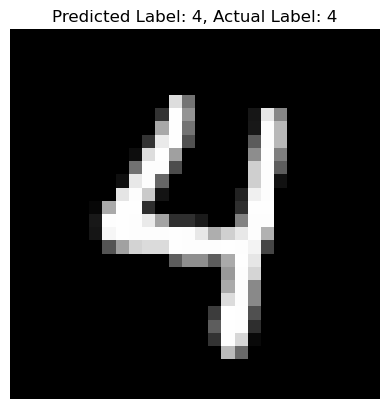

In [47]:
image_index = 27
test_image, test_label = test_dataset[image_index]

cpu_image = test_image
test_image = torch.Tensor(test_image).to(device)

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = cpu_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

## Part 2

### PyTorch FC ANN FMNIST Implementation


### Load Dataset

In [26]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

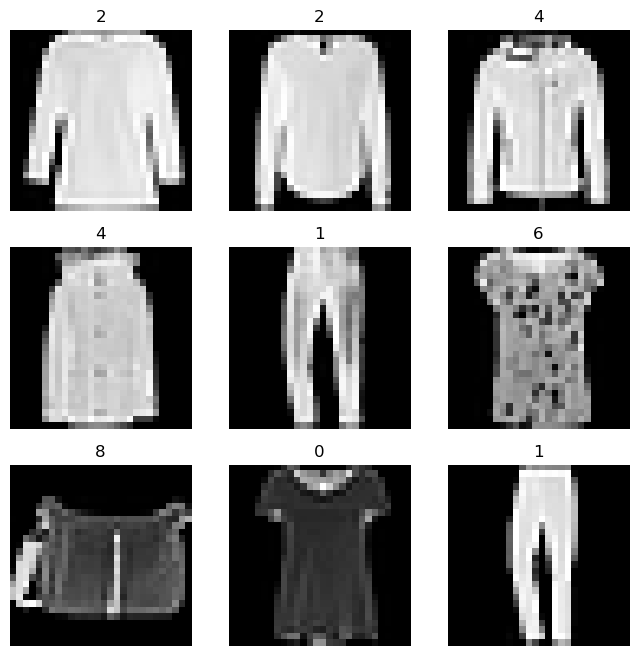

In [28]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Define the Model

In [29]:
# This is identical to the Part 1 Model
class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self, inputs, neurons, dropout, activation): #this initializes the structure of the network
    #def __init__(self): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(inputs, neurons[0]) ## First fully connected linear layer, 28*28 input features and 32 outputs
        for layer in range(2,len(neurons)): # Create the remaining fully connected layers, based on the given size of the outputs
            setattr(self, f'fc{layer}', nn.Linear(neurons[layer-2], neurons[layer-1])) # Of course, the input is the size of the previous output
            if (dropout == True) and (layer % 2 == 0): # If the dropout flag is set, add a dropout layer every 2 layers
                self.dropout = torch.nn.Dropout(0.2)
        setattr(self, f'fc{len(neurons)}', nn.Linear(neurons[len(neurons)-2], neurons[len(neurons)-1])) ## 10 output features because MNIST has 10 target classes
        self.size = len(neurons)
        self.activation = activation # Define the array of activation functions
    
    def forward(self, train_data): #this modifies the elements of the intial structure defined above
        train_data = train_data.view(-1, 28 * 28) #the array is sent in as a vector
        for layer in range(1,self.size):
            train_data = getattr(torch, f'{self.activation[layer-1]}')(getattr(self, f'fc{layer}')(train_data)) # Set the activation functions for each layer, except the output layer
        train_data = getattr(self, f'fc{self.size}')(train_data) # No modifications to the activation of the output layer, that's handled by the optimizer
        return train_data

    def fit(self, train_loader, optimizer, loss_function, learning_rate, weight_decay, batch_size, epochs): # Aside from the tensor changes, this was left alone
        criterion = getattr(nn, f'{loss_function}')()
        optimizer = getattr(optim, f'{optimizer}')(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device) # These both have to be cast to GPU tensors or it implodes
                labels = torch.Tensor(labels).to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % batch_size == (batch_size - 1):  # print every 100 mini-batches
                    print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                    running_loss = 0.0

    def score(self, test_data): # Like the above method, no changes except to the GPU tensors
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_data:
                images, labels = data
                images = torch.Tensor(images).to(device) # These.  Still have to be cast to GPU
                labels = torch.Tensor(labels).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        score = correct / total
        print(f'Accuracy on test set: {score}%')
        return score

In [15]:
model = MLP((28*28), [30, 10, 10], True, ['sigmoid', 'relu'])
model.to(device)
model.fit(train_loader, 'SGD', 'CrossEntropyLoss', 0.002, 0, 100, 3)
#print(model)

Epoch 1, Batch 100, Loss: 2.307286038398743
Epoch 1, Batch 200, Loss: 2.3088797521591187
Epoch 1, Batch 300, Loss: 2.3039369440078734
Epoch 1, Batch 400, Loss: 2.2976331067085267
Epoch 1, Batch 500, Loss: 2.297868027687073
Epoch 1, Batch 600, Loss: 2.2919821763038635
Epoch 1, Batch 700, Loss: 2.289518640041351
Epoch 1, Batch 800, Loss: 2.2844664359092715
Epoch 1, Batch 900, Loss: 2.2793776321411134
Epoch 2, Batch 100, Loss: 2.272441165447235
Epoch 2, Batch 200, Loss: 2.268027946949005
Epoch 2, Batch 300, Loss: 2.2616769790649416
Epoch 2, Batch 400, Loss: 2.25360337972641
Epoch 2, Batch 500, Loss: 2.247072057723999
Epoch 2, Batch 600, Loss: 2.2446549129486084
Epoch 2, Batch 700, Loss: 2.234690775871277
Epoch 2, Batch 800, Loss: 2.2243023347854614
Epoch 2, Batch 900, Loss: 2.2157741498947146
Epoch 3, Batch 100, Loss: 2.202964475154877
Epoch 3, Batch 200, Loss: 2.18995888710022
Epoch 3, Batch 300, Loss: 2.183020496368408
Epoch 3, Batch 400, Loss: 2.169453191757202
Epoch 3, Batch 500, Loss

In [16]:
model.score(test_loader)

Accuracy on test set: 0.1858%


0.1858

### Define Hyperparameters

In [34]:
# Define the range of parameters for the grid search
parameters = {
    'inputs': 28*28,
    'number_of_layers': [1, 2, 3, 4],
    'outputs': 10,
    'neurons_per_layer': [10, 10, 20, 20, 30, 30, 40, 40, 50, 50],
    'dropout_layers': [False, True],
    'activation_functions': ['relu', 'tanh', 'sigmoid'],
    'optimizers': ['Adam', 'SGD'],
    'learning_rates': [0.01, 0.03, 0.1, 0.3],
    'weight_decays': [0, 0.01, 0.03, 0.1, 0.3],
    'loss_functions': ['CrossEntropyLoss'],
    'batches': [50, 100, 200],
    'epochs': [25] # This is going to take so long that I decided to keep it short
}

results = {}
best_parameters = {}
worst_parameters = {}
for parameter in parameters:
    results[parameter] = []
    best_parameters[parameter] = None
    worst_parameters[parameter] = None

results['score'] = []
best_parameters['score'] = -1
worst_parameters['score'] = 1
combination = 0
local_layers = {'neurons':[],'activations':[]}

### Train the Model

In [35]:
# Much more reasonable Randomized Greedy grid search that only brute forces the number of layers, neurons per layer, and optimization functions,
# which has been modified from the above to do ~80 combinations, as each number of neurons per layer is tried twice. The weight decay and learning
# rate are also more restrictive
for number_of_layers in parameters['number_of_layers']:
    for neurons_per_layer in parameters['neurons_per_layer']:
        for optimizer in parameters['optimizers']:

            #{'neurons': [30], 'activation': ['relu']}
            #number_of_layers = 3

            dropout_layer = random.choice(parameters['dropout_layers'])
            activation_function = random.choice(parameters['activation_functions'])
            learning_rate = random.choice(parameters['learning_rates'])
            weight_decay = random.choice(parameters['weight_decays'])
            loss_function = random.choice(parameters['loss_functions']) # I'm aware that there is only a single loss function, I'm just treating it the same as everything else
            batch = random.choice(parameters['batches'])
            epochs = random.choice(parameters['epochs'])
            
                                     
            # Create the network architecture                       
            neurons = [] # Neurons array to store the neurons_per_layer
            activations = [] # Activations array to store the activations per layer
            if len(local_layers['neurons']) < number_of_layers: # If there aren't yet enough "best performing" neurons for the layer it's on, toss something in it
                local_layers['neurons'].append(neurons_per_layer)
                local_layers['activations'].append(activation_function)
            for layer in range(0,number_of_layers-1): # Add in the "best" results from the previous layers, if any
                neurons.append(local_layers['neurons'][layer])
                activations.append(local_layers['activations'][layer])
            neurons.append(neurons_per_layer) # Add the current number of neurons being tested for this layer
            activations.append(activation_function) # Add the current (random) activation function being tested for this layer
            neurons.append(parameters['outputs']) # For the final output layer, meaning we always have number_of_layers + 1 total layers
            # PLEASE NOTE: the optimizer handles the softmax function on the output, so no softmax activation is added, meaning
            # the activations array will always be one shorter than the neurons array
    
            print(f"Fitting for combination {combination}")

            # Save the current hyperparameters into results
            results['number_of_layers'].append(number_of_layers)
            results['neurons_per_layer'].append(neurons)
            results['dropout_layers'].append(dropout_layer)
            results['activation_functions'].append(activations)
            results['optimizers'].append(optimizer)
            results['learning_rates'].append(learning_rate)
            results['weight_decays'].append(weight_decay)
            results['loss_functions'].append(loss_function)
            results['batches'].append(batch)
            results['epochs'].append(epochs)
            results['inputs'].append(parameters['inputs'])
            results['outputs'].append(parameters['outputs'])
            results['score'].append(0)

            for parameter in results:
                print(results[parameter][combination])
            
            model = MLP((parameters['inputs']), neurons, dropout_layer, activations)
            model.to(device)
            model.fit(train_loader, optimizer, loss_function, learning_rate, weight_decay, batch, epochs)
            
            # Evaluate the model on the validation data
            score = model.score(test_loader)
            results['score'][combination] = score
            
            # If the current score is better than the best score, update the best score, best parameters, and save the architecture into local_layers
            # This is what makes the algorithm "greedy" instead of brute force
            if score > best_parameters['score']:
                for parameter in results:
                    best_parameters[parameter] = results[parameter][combination]
                local_layers['neurons'] = neurons
                local_layers['activations'] = activations
            elif score < worst_parameters['score']:
                for parameter in results:
                    worst_parameters[parameter] = results[parameter][combination]
            
            combination += 1

print('Best parameters:', best_parameters)

Fitting for combination 0
784
1
10
[10, 10]
True
['relu']
Adam
0.1
0.1
CrossEntropyLoss
200
25
0
Epoch 1, Batch 200, Loss: 4.147810602188111
Epoch 1, Batch 400, Loss: 4.05073757648468
Epoch 1, Batch 600, Loss: 3.742501095533371
Epoch 1, Batch 800, Loss: 4.0115821838378904
Epoch 2, Batch 200, Loss: 3.633005305528641
Epoch 2, Batch 400, Loss: 3.831987998485565
Epoch 2, Batch 600, Loss: 4.102848808765412
Epoch 2, Batch 800, Loss: 3.938613874912262
Epoch 3, Batch 200, Loss: 4.264614531993866
Epoch 3, Batch 400, Loss: 3.814323523044586
Epoch 3, Batch 600, Loss: 4.157729009389877
Epoch 3, Batch 800, Loss: 4.0674411642551425
Epoch 4, Batch 200, Loss: 3.6967059659957884
Epoch 4, Batch 400, Loss: 4.317996252775192
Epoch 4, Batch 600, Loss: 4.101454836130142
Epoch 4, Batch 800, Loss: 4.687651757001877
Epoch 5, Batch 200, Loss: 3.33524951338768
Epoch 5, Batch 400, Loss: 3.5590685093402863
Epoch 5, Batch 600, Loss: 3.6729763174057006
Epoch 5, Batch 800, Loss: 3.4878467071056365
Epoch 6, Batch 200,

In [36]:
print(best_parameters)
print(worst_parameters)

{'inputs': 784, 'number_of_layers': 1, 'outputs': 10, 'neurons_per_layer': [40, 10, 10, 10], 'dropout_layers': True, 'activation_functions': ['relu', 'sigmoid', 'relu'], 'optimizers': 'SGD', 'learning_rates': 0.03, 'weight_decays': 0, 'loss_functions': 'CrossEntropyLoss', 'batches': 100, 'epochs': 25, 'score': 0.8762}
{'inputs': 784, 'number_of_layers': 2, 'outputs': 10, 'neurons_per_layer': [40, 30, 10], 'dropout_layers': True, 'activation_functions': ['relu', 'tanh'], 'optimizers': 'Adam', 'learning_rates': 0.3, 'weight_decays': 0.01, 'loss_functions': 'CrossEntropyLoss', 'batches': 200, 'epochs': 25, 'score': 0.0902}


Like with the above, the best_parameters dict hates me.  These are the true best parameters:

784
1
10
[40, 10]
True+
['relu']
SGD
0.03
0
CrossEntropyLoss
100
25
0

In [37]:
with open("fmnist_without_augments.csv", "w", newline="") as file:
    writer = csv.DictWriter(file, results.keys())
    writer.writeheader()
    writer.writerow(results)

### Evaluate the Best Model

In [39]:
model = MLP((28*28), [40, 10], False, ['relu'])
model.to(device)
model.fit(train_loader, 'SGD', 'CrossEntropyLoss', 0.03, 0, 100, 25)
score = model.score(test_loader)

Epoch 1, Batch 100, Loss: 1.22136863052845
Epoch 1, Batch 200, Loss: 0.7058444607257843
Epoch 1, Batch 300, Loss: 0.6346086165308953
Epoch 1, Batch 400, Loss: 0.5791755375266076
Epoch 1, Batch 500, Loss: 0.5363850125670433
Epoch 1, Batch 600, Loss: 0.5299435216188431
Epoch 1, Batch 700, Loss: 0.5316382467746734
Epoch 1, Batch 800, Loss: 0.493985775411129
Epoch 1, Batch 900, Loss: 0.4894328972697258
Epoch 2, Batch 100, Loss: 0.4958282372355461
Epoch 2, Batch 200, Loss: 0.4603382143378258
Epoch 2, Batch 300, Loss: 0.4666664496064186
Epoch 2, Batch 400, Loss: 0.47181703269481656
Epoch 2, Batch 500, Loss: 0.4661540172994137
Epoch 2, Batch 600, Loss: 0.4397779616713524
Epoch 2, Batch 700, Loss: 0.43731684803962706
Epoch 2, Batch 800, Loss: 0.43729307502508163
Epoch 2, Batch 900, Loss: 0.4297910232841968
Epoch 3, Batch 100, Loss: 0.4190805853903294
Epoch 3, Batch 200, Loss: 0.42640316888689994
Epoch 3, Batch 300, Loss: 0.4432858529686928
Epoch 3, Batch 400, Loss: 0.4356191121041775
Epoch 3, 

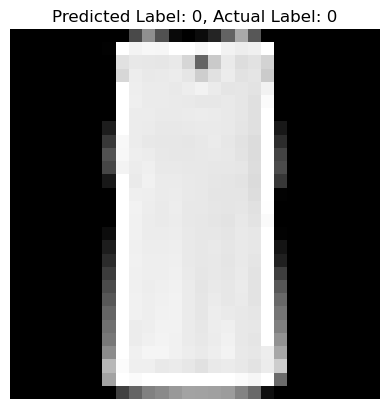

In [40]:
image_index = 27
test_image, test_label = test_dataset[image_index]

cpu_image = test_image
test_image = torch.Tensor(test_image).to(device)

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = cpu_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

## Part 3

### FMNIST CNN Implimentation with Keras

### Load Dataset

In [48]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [49]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

### Define the Model

In [50]:
# Define a function to create the CNN model. I wanted to do a class like the above two, but I'm lazy
def cnn_model(inputs, conv2d_outputs, kernels, dense_outputs, conv2d_activations, dense_activations, dropout):
    model = Sequential()
    model.add(Input(inputs))
    for layer in range(0,len(conv2d_outputs)):
        model.add(Conv2D(conv2d_outputs[layer], kernels[layer], activation=conv2d_activations[layer]))
        if (layer % 2 == 1):
            model.add(MaxPooling2D(kernels[layer]))
        elif (layer != 0) and (layer % 2 == 0) and (dropout == True):
            model.add(Dropout(0.1))
    model.add(Flatten())
    for layer in range(0,(len(dense_outputs)-1)):
        model.add(Dense(dense_outputs[layer], activation=dense_activations[layer]))
        if (dropout == True):
            model.add(Dropout(0.5))
    model.add(Dense(dense_outputs[(len(dense_outputs)-1)], activation=dense_activations[(len(dense_activations)-1)]))
    return model

In [14]:
# Test the above with an example model
model = cnn_model((28, 28, 1), [32, 64], [(5,5), (3,3)], [128, 10], ['sigmoid', 'tanh'], ['sigmoid'], False)

model.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=48, verbose=1)

loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

2024-10-13 19:03:20.200078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 19:03:20.200125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 19:03:20.200135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 19:03:20.276033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 19:03:20.276066: I tensorflow/compile

Epoch 1/5


2024-10-13 19:03:21.598587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-10-13 19:03:21.723721: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-10-13 19:03:21.723744: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-10-13 19:03:21.723790: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-10-13 19:03:22.936573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 5s 3ms/step - loss: 2.0546 - accuracy: 0.3072
Epoch 2/5
1250/1250 [==============================] - 3s 3ms/step - loss: 0.9293 - accuracy: 0.6917
Epoch 3/5
1250/1250 [==============================] - 3s 2ms/step - loss: 0.7309 - accuracy: 0.7372
Epoch 4/5
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6604 - accuracy: 0.7563
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6227 - accuracy: 0.7677
Test accuracy: 0.7677000164985657


In [15]:
model.layers

### Define Hyperparameters

In [11]:
# Define the range of parameters for the grid search
parameters = {
    'network_inputs': (28, 28, 1),
    'conv2d_layers': [1, 2, 3, 4],
    'conv2d_outputs': [32, 64, 128],
    'kernels': [(2, 2), (3, 3), (4, 4), (5, 5)],
    'dense_layers': [1, 2, 3],
    'dense_outputs': [16, 32, 64, 128],
    'network_output': 10,
    'dropout_layers': [False, True],
    'conv2d_activations': ['relu', 'tanh', 'sigmoid'],
    'dense_activations': ['relu', 'tanh', 'sigmoid'],
    'optimizers': ['Adam', 'SGD'],
    'learning_rates': [0.01, 0.03, 0.1, 0.3],
    'weight_decays': [0, 0.01, 0.03],
    'loss_functions': ['categorical_crossentropy'],
    'batches': [50, 100, 150, 200, 300],
    'epochs': [25] # This is going to take so long that I decided to keep it short
}

results = {}
best_parameters = {}
worst_parameters = {}
for parameter in parameters:
    results[parameter] = []
    best_parameters[parameter] = None
    worst_parameters[parameter] = None

results['accuracy'] = []
best_parameters['accuracy'] = -1
worst_parameters['accuracy'] = 1
combination = 0
local_layers = {'conv2d_outputs':[], 'kernels':[], 'conv2d_activations':[]}

### Train the Model

In [12]:
# Much more reasonable Randomized Greedy grid search that only brute forces the number of layers, neurons per layer, and optimization functions,
# which calculates ~40 different combination (~3.5 hours). All other parameters are chosen randomly during each iteration
for conv2d_layer in parameters['conv2d_layers']:
    for conv2d_output in parameters['conv2d_outputs']:
        #for dense_layer in parameters['dense_layers']:
            #for dense_output in parameters['dense_outputs']:
        for optimizer in parameters['optimizers']:
            for batch in parameters['batches']:

                # Randomly select all other hyperparameters
                network_input = parameters['network_inputs']
                network_output = parameters['network_output']
                kernel = random.choice(parameters['kernels'])
                dense_layer = random.choice(parameters['dense_layers'])
                dropout_layer = random.choice(parameters['dropout_layers'])
                conv2d_activation = random.choice(parameters['conv2d_activations'])
                dense_activation = random.choice(parameters['dense_activations'])
                learning_rate = random.choice(parameters['learning_rates'])
                weight_decay = random.choice(parameters['weight_decays'])
                loss_function = random.choice(parameters['loss_functions']) # I'm aware that there is only a single loss function, I'm just treating it the same as everything else
                batch = random.choice(parameters['batches'])
                epochs = random.choice(parameters['epochs'])
                                         
                # Define the convolutional layer architecture
                conv2d_outputs = []
                conv2d_activations = []
                kernels = []
                if len(local_layers['conv2d_outputs']) < conv2d_layer: # This works like the above two parts
                    local_layers['conv2d_outputs'].append(conv2d_output)
                    local_layers['conv2d_activations'].append(conv2d_activation)
                    local_layers['kernels'].append(kernel)
                for layer in range(0,conv2d_layer-1):
                    conv2d_outputs.append(local_layers['conv2d_outputs'][layer])
                    conv2d_activations.append(local_layers['conv2d_activations'][layer])
                    kernels.append(local_layers['kernels'][layer])
                conv2d_outputs.append(conv2d_output)
                conv2d_activations.append(conv2d_activation)
                kernels.append(kernel)
                        
                    #conv2d_outputs += local_layers['conv2d_outputs']
                    #conv2d_outputs.append(conv2d_output)
                    #conv2d_activations += local_layers['conv2d_activations']
                    #conv2d_activations.append(conv2d_activation)
                    #kernels += local_layers['kernels']
                    #kernels.append(kernel)

                # Define the dense layer architecture
                dense_outputs = []
                dense_activations = []
                for layer in range(0,dense_layer): # Unlike all of the above, this is always purely random
                    dense_outputs.append(random.choice(parameters['dense_outputs']))
                    dense_activations.append(random.choice(parameters['dense_activations']))                
                dense_outputs.append(network_output) # Except for the final output layer, that needs to about 10 features
                dense_activations.append('softmax') # And it needs softmax
        
                print(f"Fitting for combination {combination}")

                # Save the current hyperparameters to results
                results['conv2d_layers'].append(conv2d_layer)
                results['conv2d_outputs'].append(conv2d_outputs)
                results['dense_layers'].append(dense_layer)
                results['dense_outputs'].append(dense_outputs)
                results['kernels'].append(kernels)
                results['dropout_layers'].append(dropout_layer)
                results['conv2d_activations'].append(conv2d_activations)
                results['dense_activations'].append(dense_activations)
                results['optimizers'].append(optimizer)
                results['learning_rates'].append(learning_rate)
                results['weight_decays'].append(weight_decay)
                results['loss_functions'].append(loss_function)
                results['batches'].append(batch)
                results['epochs'].append(epochs)
                results['network_inputs'].append(network_input)
                results['network_output'].append(network_output)
                results['accuracy'].append(0)

    
                for parameter in results:
                    print(results[parameter][combination])

                # Build the model
                model = cnn_model(network_input, conv2d_outputs, kernels, dense_outputs, conv2d_activations, dense_activations, dropout_layer)

                # Since this architecture requires compile statements, I'm just doing those here with an if/then
                if optimizer == 'SGD':
                    model.compile(optimizer=SGD(learning_rate=learning_rate,
                          decay=weight_decay),
                          loss=loss_function,
                          metrics=['accuracy'])
                elif optimizer == 'Adam':
                    model.compile(optimizer=Adam(learning_rate=learning_rate,
                          decay=weight_decay),
                          loss=loss_function,
                          metrics=['accuracy'])

                # Train the model
                model.fit(x_train, y_train, epochs=epochs, batch_size=batch, verbose=1)
                
                # Evaluate the model on the validation data
                loss, accuracy = model.evaluate(x_test, y_test)
                results['accuracy'][combination] = accuracy
                
                # If the current score is better than the best score, update the best score, best parameters, and local_layers
                if accuracy > best_parameters['accuracy']:
                    for parameter in results:
                        best_parameters[parameter] = results[parameter][combination]
                    local_layers['conv2d_outputs'] = conv2d_outputs
                    local_layers['conv2d_activations'] = conv2d_activations
                    local_layers['kernels'] = kernels
                elif accuracy < worst_parameters['accuracy']:
                    for parameter in results:
                        worst_parameters[parameter] = results[parameter][combination]
                
                combination += 1


print('Best parameters:', best_parameters)

Fitting for combination 0
(28, 28, 1)
1
[32]
[(2, 2)]
1
[128, 10]
10
True
['relu']
['relu', 'softmax']
Adam
0.03
0.03
categorical_crossentropy
300
25
0


2024-10-14 08:53:03.201593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 08:53:03.201635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 08:53:03.201643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 08:53:03.274130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 08:53:03.274163: I tensorflow/compile

Epoch 1/25


2024-10-14 08:53:04.623163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-10-14 08:53:04.739081: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-10-14 08:53:04.739106: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-10-14 08:53:04.739138: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  1/200 [..............................] - ETA: 6:09 - loss: 2.3013 - accuracy: 0.0967

2024-10-14 08:53:06.110493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


200/200 [==============================] - 3s 3ms/step - loss: 0.8887 - accuracy: 0.7944
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3631 - accuracy: 0.8707
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8852
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 0.3032 - accuracy: 0.8913
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 0.2905 - accuracy: 0.8967
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 0.2806 - accuracy: 0.8996
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 0.2699 - accuracy: 0.9044
Epoch 8/25
200/200 [==============================] - 1s 3ms/step - loss: 0.2642 - accuracy: 0.9056
Epoch 9/25
200/200 [==============================] - 1s 3ms/step - loss: 0.2568 - accuracy: 0.9077
Epoch 10/25
200/200 [==============================] - 1s 3ms/step - loss: 0.2532 - accuracy: 0.9091
Epoch 11/2

2024-10-14 09:39:41.577987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_60/dropout_74/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 4ms/step - loss: 2.3597 - accuracy: 0.1014
Epoch 2/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3062 - accuracy: 0.0998
Epoch 3/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3048 - accuracy: 0.1011
Epoch 4/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3043 - accuracy: 0.0994
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3037 - accuracy: 0.0998
Epoch 6/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3037 - accuracy: 0.0987
Epoch 7/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3034 - accuracy: 0.1004
Epoch 8/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3033 - accuracy: 0.0998
Epoch 9/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0989
Epoch 10/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3033 - accuracy: 0.0989
Epoch 11/2

2024-10-14 09:40:06.829016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_61/dropout_77/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 3ms/step - loss: 2.3393 - accuracy: 0.1027
Epoch 2/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3040 - accuracy: 0.0999
Epoch 3/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3034 - accuracy: 0.0984
Epoch 4/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3031 - accuracy: 0.0991
Epoch 5/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3030 - accuracy: 0.1000
Epoch 6/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3031 - accuracy: 0.0994
Epoch 7/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3029 - accuracy: 0.1005
Epoch 8/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3029 - accuracy: 0.0988
Epoch 9/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3028 - accuracy: 0.0989
Epoch 10/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3029 - accuracy: 0.0991
Epoch 11/2

2024-10-14 09:40:40.676736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_62/dropout_81/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 2s 4ms/step - loss: 2.3478 - accuracy: 0.1019
Epoch 2/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3088 - accuracy: 0.0994
Epoch 3/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3064 - accuracy: 0.1000
Epoch 4/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3056 - accuracy: 0.1010
Epoch 5/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3049 - accuracy: 0.0992
Epoch 6/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3045 - accuracy: 0.0978
Epoch 7/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3043 - accuracy: 0.1002
Epoch 8/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3042 - accuracy: 0.0986
Epoch 9/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3037 - accuracy: 0.1008
Epoch 10/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3040 - accuracy: 0.0983
Epoch 11/2

2024-10-14 09:41:09.734934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_63/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 4ms/step - loss: 2.3433 - accuracy: 0.1016
Epoch 2/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3121 - accuracy: 0.0985
Epoch 3/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3106 - accuracy: 0.0979
Epoch 4/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3066 - accuracy: 0.1021
Epoch 5/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3059 - accuracy: 0.0996
Epoch 6/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3051 - accuracy: 0.0986
Epoch 7/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3045 - accuracy: 0.1018
Epoch 8/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3043 - accuracy: 0.0988
Epoch 9/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3038 - accuracy: 0.1017
Epoch 10/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3040 - accuracy: 0.0997
Epoch 11/2

2024-10-14 09:41:32.363881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_64/dropout_87/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 5ms/step - loss: 2.3067 - accuracy: 0.0983
Epoch 2/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0991
Epoch 3/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3030 - accuracy: 0.1006
Epoch 4/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.1001
Epoch 5/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3030 - accuracy: 0.0997
Epoch 6/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0979
Epoch 7/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0989
Epoch 8/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0985
Epoch 9/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0996
Epoch 10/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.0991
Epoch 11/2

2024-10-14 09:43:09.872724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_66/dropout_91/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 4ms/step - loss: 2.3194 - accuracy: 0.1014
Epoch 2/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3038 - accuracy: 0.1007
Epoch 3/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3035 - accuracy: 0.0993
Epoch 4/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3034 - accuracy: 0.0981
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3035 - accuracy: 0.0994
Epoch 6/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3034 - accuracy: 0.0991
Epoch 7/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3035 - accuracy: 0.0995
Epoch 8/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3036 - accuracy: 0.1006
Epoch 9/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3034 - accuracy: 0.1015
Epoch 10/25
200/200 [==============================] - 1s 4ms/step - loss: 2.3037 - accuracy: 0.1007
Epoch 11/2

2024-10-14 09:43:33.321016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_67/dropout_95/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


600/600 [==============================] - 2s 3ms/step - loss: 2.3620 - accuracy: 0.1006
Epoch 2/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3362 - accuracy: 0.1013
Epoch 3/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3312 - accuracy: 0.1014
Epoch 4/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3300 - accuracy: 0.1010
Epoch 5/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3275 - accuracy: 0.0993
Epoch 6/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3275 - accuracy: 0.0983
Epoch 7/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3242 - accuracy: 0.1015
Epoch 8/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3244 - accuracy: 0.1002
Epoch 9/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3246 - accuracy: 0.0993
Epoch 10/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3234 - accuracy: 0.0996
Epoch 11/2

2024-10-14 09:46:06.088487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_70/dropout_99/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 3ms/step - loss: 2.4663 - accuracy: 0.1019
Epoch 2/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3220 - accuracy: 0.0998
Epoch 3/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3164 - accuracy: 0.0977
Epoch 4/25
400/400 [==============================] - 1s 4ms/step - loss: 2.3127 - accuracy: 0.0999
Epoch 5/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3107 - accuracy: 0.1008
Epoch 6/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3093 - accuracy: 0.0991
Epoch 7/25
400/400 [==============================] - 1s 4ms/step - loss: 2.3083 - accuracy: 0.1012
Epoch 8/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3084 - accuracy: 0.0994
Epoch 9/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3070 - accuracy: 0.0989
Epoch 10/25
400/400 [==============================] - 1s 3ms/step - loss: 2.3072 - accuracy: 0.0993
Epoch 11/2

2024-10-14 09:48:27.124053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_74/dropout_101/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.3977 - accuracy: 0.1006
Epoch 2/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3260 - accuracy: 0.0988
Epoch 3/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3168 - accuracy: 0.0998
Epoch 4/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3126 - accuracy: 0.1012
Epoch 5/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3108 - accuracy: 0.0996
Epoch 6/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3084 - accuracy: 0.1015
Epoch 7/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3084 - accuracy: 0.0991
Epoch 8/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3077 - accuracy: 0.0981
Epoch 9/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3069 - accuracy: 0.1005
Epoch 10/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3062 - accurac

2024-10-14 09:49:54.837948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_75/dropout_104/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.4312 - accuracy: 0.1037
Epoch 2/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3991 - accuracy: 0.0996
Epoch 3/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3892 - accuracy: 0.0997
Epoch 4/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3844 - accuracy: 0.0992
Epoch 5/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3809 - accuracy: 0.1005
Epoch 6/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3756 - accuracy: 0.1020
Epoch 7/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3751 - accuracy: 0.0990
Epoch 8/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3737 - accuracy: 0.0990
Epoch 9/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3723 - accuracy: 0.0991
Epoch 10/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3706 - accurac

2024-10-14 09:51:17.218837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_76/dropout_108/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 3ms/step - loss: 2.2983 - accuracy: 0.1150
Epoch 2/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2889 - accuracy: 0.1269
Epoch 3/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2831 - accuracy: 0.1325
Epoch 4/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2778 - accuracy: 0.1407
Epoch 5/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2725 - accuracy: 0.1448
Epoch 6/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2678 - accuracy: 0.1520
Epoch 7/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2629 - accuracy: 0.1548
Epoch 8/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2594 - accuracy: 0.1590
Epoch 9/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2550 - accuracy: 0.1633
Epoch 10/25
400/400 [==============================] - 1s 3ms/step - loss: 2.2515 - accuracy: 0.1679
Epoch 11/2

2024-10-14 09:51:52.002029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_77/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 3s 3ms/step - loss: 2.3414 - accuracy: 0.0997
Epoch 2/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3267 - accuracy: 0.0996
Epoch 3/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3239 - accuracy: 0.0991
Epoch 4/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3224 - accuracy: 0.1010
Epoch 5/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3231 - accuracy: 0.0988
Epoch 6/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3202 - accuracy: 0.1008
Epoch 7/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3210 - accuracy: 0.1006
Epoch 8/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3216 - accuracy: 0.0980
Epoch 9/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3197 - accuracy: 0.1000
Epoch 10/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3188 - accurac

2024-10-14 09:53:12.966973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_78/dropout_114/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 4ms/step - loss: 2.2927 - accuracy: 0.1486
Epoch 2/25
200/200 [==============================] - 1s 5ms/step - loss: 2.2621 - accuracy: 0.2415
Epoch 3/25
200/200 [==============================] - 1s 5ms/step - loss: 2.2247 - accuracy: 0.2851
Epoch 4/25
200/200 [==============================] - 1s 5ms/step - loss: 2.1711 - accuracy: 0.3099
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.1019 - accuracy: 0.3327
Epoch 6/25
200/200 [==============================] - 1s 5ms/step - loss: 2.0269 - accuracy: 0.3503
Epoch 7/25
200/200 [==============================] - 1s 5ms/step - loss: 1.9502 - accuracy: 0.3638
Epoch 8/25
200/200 [==============================] - 1s 5ms/step - loss: 1.8823 - accuracy: 0.3785
Epoch 9/25
200/200 [==============================] - 1s 5ms/step - loss: 1.8223 - accuracy: 0.3923
Epoch 10/25
200/200 [==============================] - 1s 5ms/step - loss: 1.7748 - accuracy: 0.3998
Epoch 11/2

2024-10-14 09:53:37.237158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_79/dropout_117/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 5ms/step - loss: 2.2992 - accuracy: 0.1438
Epoch 2/25
200/200 [==============================] - 1s 4ms/step - loss: 2.2842 - accuracy: 0.2197
Epoch 3/25
200/200 [==============================] - 1s 4ms/step - loss: 2.2703 - accuracy: 0.2662
Epoch 4/25
200/200 [==============================] - 1s 4ms/step - loss: 2.2518 - accuracy: 0.2867
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.2285 - accuracy: 0.3057
Epoch 6/25
200/200 [==============================] - 1s 4ms/step - loss: 2.1996 - accuracy: 0.3181
Epoch 7/25
200/200 [==============================] - 1s 4ms/step - loss: 2.1652 - accuracy: 0.3252
Epoch 8/25
200/200 [==============================] - 1s 5ms/step - loss: 2.1251 - accuracy: 0.3318
Epoch 9/25
200/200 [==============================] - 1s 5ms/step - loss: 2.0801 - accuracy: 0.3394
Epoch 10/25
200/200 [==============================] - 1s 4ms/step - loss: 2.0346 - accuracy: 0.3449
Epoch 11/2

2024-10-14 09:55:34.258522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_83/dropout_119/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 2s 4ms/step - loss: 2.4846 - accuracy: 0.1002
Epoch 2/25
300/300 [==============================] - 1s 4ms/step - loss: 2.5051 - accuracy: 0.1000
Epoch 3/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4774 - accuracy: 0.1004
Epoch 4/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4656 - accuracy: 0.1016
Epoch 5/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4688 - accuracy: 0.1009
Epoch 6/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4616 - accuracy: 0.0998
Epoch 7/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4566 - accuracy: 0.1015
Epoch 8/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4653 - accuracy: 0.1001
Epoch 9/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4725 - accuracy: 0.1002
Epoch 10/25
300/300 [==============================] - 1s 4ms/step - loss: 2.4734 - accuracy: 0.1019
Epoch 11/2

2024-10-14 09:56:06.045920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_84/dropout_122/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


600/600 [==============================] - 2s 3ms/step - loss: 2.3494 - accuracy: 0.0997
Epoch 2/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3045 - accuracy: 0.1007
Epoch 3/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3040 - accuracy: 0.1001
Epoch 4/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3037 - accuracy: 0.0984
Epoch 5/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3034 - accuracy: 0.0996
Epoch 6/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3033 - accuracy: 0.0983
Epoch 7/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3031 - accuracy: 0.0997
Epoch 8/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3031 - accuracy: 0.1010
Epoch 9/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3031 - accuracy: 0.0996
Epoch 10/25
600/600 [==============================] - 2s 3ms/step - loss: 2.3031 - accuracy: 0.1007
Epoch 11/2

2024-10-14 09:59:50.452479: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_89/dropout_124/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.3071 - accuracy: 0.0979
Epoch 2/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3035 - accuracy: 0.1006
Epoch 3/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3038 - accuracy: 0.1003
Epoch 4/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3036 - accuracy: 0.1006
Epoch 5/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3032 - accuracy: 0.0998
Epoch 6/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3036 - accuracy: 0.0988
Epoch 7/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3034 - accuracy: 0.1007
Epoch 8/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3030 - accuracy: 0.1002
Epoch 9/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3034 - accuracy: 0.0997
Epoch 10/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3030 - accurac

2024-10-14 10:01:13.640572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_90/dropout_127/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.3215 - accuracy: 0.0993
Epoch 2/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3033 - accuracy: 0.0988
Epoch 3/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3030 - accuracy: 0.0998
Epoch 4/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3029 - accuracy: 0.0979
Epoch 5/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0984
Epoch 6/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3028 - accuracy: 0.0989
Epoch 7/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0987
Epoch 8/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0966
Epoch 9/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0986
Epoch 10/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3027 - accurac

2024-10-14 10:02:42.525966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_91/dropout_130/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 4ms/step - loss: 2.3053 - accuracy: 0.0987
Epoch 2/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3028 - accuracy: 0.0995
Epoch 3/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.1005
Epoch 4/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0986
Epoch 5/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0986
Epoch 6/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0962
Epoch 7/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0975
Epoch 8/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.1002
Epoch 9/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.1004
Epoch 10/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0979
Epoch 11/2

2024-10-14 10:03:50.690455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_93/dropout_133/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 4ms/step - loss: 2.3398 - accuracy: 0.0997
Epoch 2/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3107 - accuracy: 0.0985
Epoch 3/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3070 - accuracy: 0.1011
Epoch 4/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3060 - accuracy: 0.1015
Epoch 5/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3053 - accuracy: 0.1013
Epoch 6/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3050 - accuracy: 0.0992
Epoch 7/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3045 - accuracy: 0.1014
Epoch 8/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3041 - accuracy: 0.1001
Epoch 9/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3042 - accuracy: 0.0999
Epoch 10/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3038 - accuracy: 0.1003
Epoch 11/2

2024-10-14 10:04:33.021932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_94/dropout_137/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 5ms/step - loss: 2.3970 - accuracy: 0.1010
Epoch 2/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3037 - accuracy: 0.1008
Epoch 3/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.1007
Epoch 4/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.0982
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3030 - accuracy: 0.0994
Epoch 6/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0977
Epoch 7/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3030 - accuracy: 0.0990
Epoch 8/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3029 - accuracy: 0.0993
Epoch 9/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3029 - accuracy: 0.0983
Epoch 10/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3029 - accuracy: 0.0977
Epoch 11/2

2024-10-14 10:05:00.601405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_95/dropout_139/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 5ms/step - loss: 2.3029 - accuracy: 0.0986
Epoch 2/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0994
Epoch 3/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.1013
Epoch 4/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.1014
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.0991
Epoch 6/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.1001
Epoch 7/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3024 - accuracy: 0.1020
Epoch 8/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3024 - accuracy: 0.1018
Epoch 9/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3023 - accuracy: 0.1024
Epoch 10/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3022 - accuracy: 0.1037
Epoch 11/2

2024-10-14 10:05:28.312304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_96/dropout_143/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 5ms/step - loss: 2.4338 - accuracy: 0.1006
Epoch 2/25
200/200 [==============================] - 1s 5ms/step - loss: 2.4076 - accuracy: 0.0993
Epoch 3/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3950 - accuracy: 0.1009
Epoch 4/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3896 - accuracy: 0.1020
Epoch 5/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3860 - accuracy: 0.1001
Epoch 6/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3840 - accuracy: 0.0968
Epoch 7/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3811 - accuracy: 0.1014
Epoch 8/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3792 - accuracy: 0.0981
Epoch 9/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3773 - accuracy: 0.0991
Epoch 10/25
200/200 [==============================] - 1s 5ms/step - loss: 2.3734 - accuracy: 0.1035
Epoch 11/2

2024-10-14 10:06:27.934030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_98/dropout_146/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 2s 4ms/step - loss: 2.3036 - accuracy: 0.1019
Epoch 2/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0990
Epoch 3/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0978
Epoch 4/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0993
Epoch 5/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3030 - accuracy: 0.1001
Epoch 6/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3030 - accuracy: 0.1001
Epoch 7/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0988
Epoch 8/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0984
Epoch 9/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3030 - accuracy: 0.0999
Epoch 10/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3031 - accuracy: 0.0981
Epoch 11/2

2024-10-14 10:09:18.070632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_102/dropout_150/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.3067 - accuracy: 0.0990
Epoch 2/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3030 - accuracy: 0.0978
Epoch 3/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0989
Epoch 4/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0972
Epoch 5/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0992
Epoch 6/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3028 - accuracy: 0.0960
Epoch 7/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3026 - accuracy: 0.0992
Epoch 8/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3027 - accuracy: 0.0961
Epoch 9/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3027 - accuracy: 0.0986
Epoch 10/25
1200/1200 [==============================] - 3s 3ms/step - loss: 2.3027 - accurac

2024-10-14 10:12:08.687067: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_104/dropout_153/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 2s 5ms/step - loss: 2.3217 - accuracy: 0.1021
Epoch 2/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3060 - accuracy: 0.0983
Epoch 3/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3043 - accuracy: 0.0984
Epoch 4/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3039 - accuracy: 0.0988
Epoch 5/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3037 - accuracy: 0.0994
Epoch 6/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3033 - accuracy: 0.0996
Epoch 7/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3033 - accuracy: 0.1000
Epoch 8/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.1002
Epoch 9/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.0991
Epoch 10/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0982
Epoch 11/2

2024-10-14 10:13:16.187889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_106/dropout_157/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 4ms/step - loss: 2.4594 - accuracy: 0.0997
Epoch 2/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4295 - accuracy: 0.1023
Epoch 3/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4318 - accuracy: 0.0981
Epoch 4/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4287 - accuracy: 0.0982
Epoch 5/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4236 - accuracy: 0.1001
Epoch 6/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4245 - accuracy: 0.0991
Epoch 7/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4149 - accuracy: 0.1021
Epoch 8/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4175 - accuracy: 0.1011
Epoch 9/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4171 - accuracy: 0.1009
Epoch 10/25
400/400 [==============================] - 2s 4ms/step - loss: 2.4154 - accuracy: 0.1006
Epoch 11/2

2024-10-14 10:14:38.756887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_108/dropout_160/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1s 6ms/step - loss: 2.3485 - accuracy: 0.1000
Epoch 2/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3151 - accuracy: 0.1014
Epoch 3/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3120 - accuracy: 0.1010
Epoch 4/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3096 - accuracy: 0.1008
Epoch 5/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3076 - accuracy: 0.1027
Epoch 6/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3081 - accuracy: 0.0988
Epoch 7/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3073 - accuracy: 0.0980
Epoch 8/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3066 - accuracy: 0.1003
Epoch 9/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3072 - accuracy: 0.1006
Epoch 10/25
200/200 [==============================] - 1s 6ms/step - loss: 2.3065 - accuracy: 0.0994
Epoch 11/2

2024-10-14 10:15:08.532245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_109/dropout_163/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 2s 4ms/step - loss: 2.3091 - accuracy: 0.0985
Epoch 2/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3036 - accuracy: 0.0997
Epoch 3/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3032 - accuracy: 0.1005
Epoch 4/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3029 - accuracy: 0.1009
Epoch 5/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.1030
Epoch 6/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3028 - accuracy: 0.1014
Epoch 7/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.1044
Epoch 8/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3025 - accuracy: 0.1038
Epoch 9/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3025 - accuracy: 0.1031
Epoch 10/25
300/300 [==============================] - 1s 4ms/step - loss: 2.3025 - accuracy: 0.1037
Epoch 11/2

2024-10-14 10:15:41.926295: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_110/dropout_166/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 4ms/step - loss: 2.3139 - accuracy: 0.1004
Epoch 2/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3059 - accuracy: 0.0994
Epoch 3/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3049 - accuracy: 0.1008
Epoch 4/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3050 - accuracy: 0.1002
Epoch 5/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3049 - accuracy: 0.0998
Epoch 6/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3048 - accuracy: 0.0991
Epoch 7/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3046 - accuracy: 0.0997
Epoch 8/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3051 - accuracy: 0.0981
Epoch 9/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3045 - accuracy: 0.0987
Epoch 10/25
400/400 [==============================] - 2s 4ms/step - loss: 2.3047 - accuracy: 0.1018
Epoch 11/2

2024-10-14 10:16:26.818205: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_111/dropout_169/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 2s 5ms/step - loss: 2.3120 - accuracy: 0.0975
Epoch 2/25
300/300 [==============================] - 2s 5ms/step - loss: 2.3029 - accuracy: 0.0998
Epoch 3/25
300/300 [==============================] - 2s 5ms/step - loss: 2.3028 - accuracy: 0.1003
Epoch 4/25
300/300 [==============================] - 2s 5ms/step - loss: 2.3029 - accuracy: 0.0971
Epoch 5/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3029 - accuracy: 0.0984
Epoch 6/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3028 - accuracy: 0.0986
Epoch 7/25
300/300 [==============================] - 1s 5ms/step - loss: 2.3027 - accuracy: 0.0993
Epoch 8/25
300/300 [==============================] - 2s 5ms/step - loss: 2.3027 - accuracy: 0.0997
Epoch 9/25
300/300 [==============================] - 2s 5ms/step - loss: 2.3027 - accuracy: 0.1018
Epoch 10/25
300/300 [==============================] - 2s 5ms/step - loss: 2.3027 - accuracy: 0.0986
Epoch 11/2

2024-10-14 10:18:29.138994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_114/dropout_173/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


600/600 [==============================] - 2s 4ms/step - loss: 2.7523 - accuracy: 0.0995
Epoch 2/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3029 - accuracy: 0.0991
Epoch 3/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0999
Epoch 4/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3028 - accuracy: 0.0984
Epoch 5/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0983
Epoch 6/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0971
Epoch 7/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0977
Epoch 8/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0988
Epoch 9/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0985
Epoch 10/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0981
Epoch 11/2

2024-10-14 10:19:23.912307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_115/dropout_175/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 2s 4ms/step - loss: 2.3072 - accuracy: 0.1052
Epoch 2/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2987 - accuracy: 0.1195
Epoch 3/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2962 - accuracy: 0.1324
Epoch 4/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2945 - accuracy: 0.1360
Epoch 5/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2926 - accuracy: 0.1476
Epoch 6/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2909 - accuracy: 0.1639
Epoch 7/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2892 - accuracy: 0.1763
Epoch 8/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2875 - accuracy: 0.1814
Epoch 9/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2855 - accuracy: 0.1821
Epoch 10/25
400/400 [==============================] - 2s 4ms/step - loss: 2.2839 - accuracy: 0.1877
Epoch 11/2

2024-10-14 10:20:09.527722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_116/dropout_177/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


600/600 [==============================] - 2s 3ms/step - loss: 2.3843 - accuracy: 0.0988
Epoch 2/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3185 - accuracy: 0.0995
Epoch 3/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3138 - accuracy: 0.1005
Epoch 4/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3117 - accuracy: 0.1003
Epoch 5/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3114 - accuracy: 0.0987
Epoch 6/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3099 - accuracy: 0.1001
Epoch 7/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3093 - accuracy: 0.0995
Epoch 8/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3091 - accuracy: 0.1014
Epoch 9/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3081 - accuracy: 0.0992
Epoch 10/25
600/600 [==============================] - 2s 4ms/step - loss: 2.3086 - accuracy: 0.0991
Epoch 11/2

2024-10-14 10:21:06.842439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_117/dropout_181/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.3320 - accuracy: 0.0978
Epoch 2/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3048 - accuracy: 0.1003
Epoch 3/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3038 - accuracy: 0.1019
Epoch 4/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3033 - accuracy: 0.1016
Epoch 5/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3036 - accuracy: 0.1009
Epoch 6/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3033 - accuracy: 0.1023
Epoch 7/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3030 - accuracy: 0.1032
Epoch 8/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3030 - accuracy: 0.1033
Epoch 9/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3030 - accuracy: 0.1018
Epoch 10/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3031 - accurac

2024-10-14 10:23:43.005002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_119/dropout_183/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 4s 3ms/step - loss: 2.3062 - accuracy: 0.1054
Epoch 2/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3015 - accuracy: 0.1069
Epoch 3/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.3002 - accuracy: 0.1108
Epoch 4/25
1200/1200 [==============================] - 4s 4ms/step - loss: 2.2993 - accuracy: 0.1117
Epoch 5/25
1200/1200 [==============================] - 4s 4ms/step - loss: 2.2990 - accuracy: 0.1144
Epoch 6/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.2985 - accuracy: 0.1154
Epoch 7/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.2984 - accuracy: 0.1167
Epoch 8/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.2982 - accuracy: 0.1161
Epoch 9/25
1200/1200 [==============================] - 4s 3ms/step - loss: 2.2980 - accuracy: 0.1153
Epoch 10/25
1200/1200 [==============================] - 4s 4ms/step - loss: 2.2978 - accurac

In [38]:
print(best_parameters)

{'network_inputs': (28, 28, 1), 'conv2d_layers': 3, 'conv2d_outputs': [32, 32, 128, 32], 'kernels': [(2, 2), (2, 2), (2, 2), (3, 3)], 'dense_layers': 2, 'dense_outputs': [16, 32, 10], 'network_output': 10, 'dropout_layers': False, 'conv2d_activations': ['relu', 'sigmoid', 'relu', 'tanh'], 'dense_activations': ['tanh', 'sigmoid', 'softmax'], 'optimizers': 'SGD', 'learning_rates': 0.1, 'weight_decays': 0, 'loss_functions': 'categorical_crossentropy', 'batches': 50, 'epochs': 25, 'accuracy': 0.9074000120162964}


Please note that like with all the others, the above is not exactly correct. These are the true best parameters:

(28, 28, 1)
3
[32, 32, 128]
[(2, 2), (2, 2), (2, 2)]
2
[16, 32, 10]
10
False
['relu', 'sigmoid', 'relu']
['tanh', 'sigmoid', 'softmax']
SGD
0.1
0
categorical_crossentropy
50
25
0

I ESPECIALLY don't want to re-run this one, as it takes like 4 hours to run.

In [14]:
with open("fmnist_cnn_without_augments.csv", "w", newline="") as file:
    writer = csv.DictWriter(file, results.keys())
    writer.writeheader()
    writer.writerow(results)

### Evaluate the Best Model

In [51]:
model = cnn_model((28, 28, 1), [32, 32, 128], [(2, 2), (2, 2), (2, 2)], [16, 32, 10], ['relu', 'sigmoid', 'relu'], ['tanh', 'sigmoid', 'softmax'], False)

model.compile(optimizer=SGD(learning_rate=0.1,
            decay=0),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.fit(x_train, y_train, epochs=25, batch_size=50, verbose=1)

loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/25
1200/1200 [==============================] - 3s 2ms/step - loss: 1.4111 - accuracy: 0.4955
Epoch 2/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.5504 - accuracy: 0.8000
Epoch 3/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.4244 - accuracy: 0.8492
Epoch 4/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3716 - accuracy: 0.8671
Epoch 5/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3403 - accuracy: 0.8771
Epoch 6/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3134 - accuracy: 0.8854
Epoch 7/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.2909 - accuracy: 0.8945
Epoch 8/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.2744 - accuracy: 0.8994
Epoch 9/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.2563 - accuracy: 0.9065
Epoch 10/25
1200/1200 [==============================] - 3s 2ms/step - loss: 0.240

In [52]:
model.layers

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 27, 27, 32)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       16512     
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                294928    
                                                      

1/1 [==============================] - 0s 97ms/step


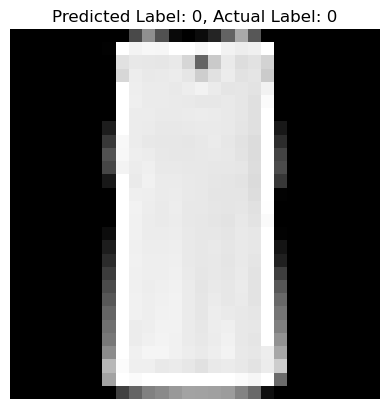

In [55]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

# Model Evaluations

The below is basically just loading the data from the saved CSVs and fixing how they're displayed.

Please note that Pandas was fighting me so much that I just manually fixed these lines in the saved .csv files before loading them:

784 1 10 [30, 10] False ['tanh'] Adam 0.001 0.01 CrossEntropyLoss 100 25 0 = 0.9315

784 1 10 [40, 10] True+ ['relu'] SGD 0.03 0 CrossEntropyLoss 100 25 0 = 0.8762

(28, 28, 1) 3 [32, 32, 128] [(2, 2), (2, 2), (2, 2)] 2 [16, 32, 10] 10 False ['relu', 'sigmoid', 'relu'] ['tanh', 'sigmoid', 'softmax'] SGD 0.1 0 categorical_crossentropy 50 25 0 = 0.9074

In [2]:
mnist_fc_df = pd.read_csv('./mnist_without_augments.csv', sep=',')
fmnist_fc_df = pd.read_csv('./fmnist_without_augments.csv', sep=',')
fmnist_cnn_df = pd.read_csv('./fmnist_cnn_without_augments.csv', sep=',')

In [3]:
fmnist_fc_df

,inputs,number_of_layers,outputs,neurons_per_layer,dropout_layers,activation_functions,optimizers,learning_rates,weight_decays,loss_functions,batches,epochs,score
0,"784, 784, 784, 784, 784, 784, 784, 784, 784, 7...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10...","[10, 10], [10, 10], [10, 10], [10, 10], [20, 1...","True, True, False, False, False, False, True, ...","['relu'], ['tanh'], ['sigmoid'], ['relu'], ['s...","'Adam', 'SGD', 'Adam', 'SGD', 'Adam', 'SGD', '...","0.1, 0.01, 0.03, 0.1, 0.1, 0.03, 0.1, 0.3, 0.1...","0.1, 0, 0.3, 0.03, 0, 0.03, 0.3, 0.03, 0.01, 0...","'CrossEntropyLoss', 'CrossEntropyLoss', 'Cross...","200, 200, 50, 100, 100, 200, 100, 50, 200, 100...","25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25...","0.1502, 0.8457, 0.2163, 0.7733, 0.6983, 0.7625..."


In [4]:
for column in mnist_fc_df:
    mnist_fc_df[column] = mnist_fc_df[column].apply(literal_eval)

for column in fmnist_fc_df:
    fmnist_fc_df[column] = fmnist_fc_df[column].apply(literal_eval)

for column in fmnist_cnn_df:
    fmnist_cnn_df[column] = fmnist_cnn_df[column].apply(literal_eval)

In [5]:
mnist_dict = {}
fmnist_dict = {}
fmnist_cnn_dict = {}
for column in mnist_fc_df:
    mnist_dict[column] = []
    for row in mnist_fc_df[column][0]:
        mnist_dict[column].append(row)

for column in fmnist_fc_df:
    fmnist_dict[column] = []
    for row in fmnist_fc_df[column][0]:
        fmnist_dict[column].append(row)

for column in fmnist_cnn_df:
    fmnist_cnn_dict[column] = []
    for row in fmnist_cnn_df[column][0]:
        fmnist_cnn_dict[column].append(row)

In [6]:
mnist_fixed_fc_df = pd.DataFrame.from_dict(mnist_dict)
fmnist_fixed_fc_df = pd.DataFrame.from_dict(fmnist_dict)
fmnist_fixed_cnn_df = pd.DataFrame.from_dict(fmnist_cnn_dict)

In [7]:
mnist_fixed_fc_df

,inputs,number_of_layers,outputs,neurons_per_layer,dropout_layers,activation_functions,optimizers,learning_rates,weight_decays,loss_functions,batches,epochs,score
0,784,1,10,"[10, 10]",False,[sigmoid],Adam,0.300,1.00,CrossEntropyLoss,300,25,0.0980
1,784,1,10,"[10, 10]",False,[relu],SGD,0.001,0.03,CrossEntropyLoss,300,25,0.8959
2,784,1,10,"[20, 10]",False,[sigmoid],Adam,0.300,1.00,CrossEntropyLoss,100,25,0.0892
3,784,1,10,"[20, 10]",True,[relu],SGD,0.003,0.30,CrossEntropyLoss,200,25,0.8162
4,784,1,10,"[30, 10]",False,[tanh],Adam,0.001,0.01,CrossEntropyLoss,100,25,0.9315
5,784,1,10,"[30, 10]",True,[sigmoid],SGD,0.010,0.01,CrossEntropyLoss,300,25,0.9059
6,784,1,10,"[40, 10]",True,[relu],Adam,0.100,0.10,CrossEntropyLoss,300,25,0.2036
7,784,1,10,"[40, 10]",False,[relu],SGD,0.300,0.03,CrossEntropyLoss,100,25,0.1135
8,784,1,10,"[50, 10]",False,[tanh],Adam,0.010,0.30,CrossEntropyLoss,100,25,0.5220
9,784,1,10,"[50, 10]",True,[relu],SGD,0.300,0.10,CrossEntropyLoss,300,25,0.1010


Now we can get into actual evaluation.

In [8]:
mnist_fc_score_df = mnist_fixed_fc_df['score']
fmnist_fc_score_df = fmnist_fixed_fc_df['score']
fmnist_cnn_score_df = fmnist_fixed_cnn_df['accuracy']

mnist_fc_scores = {'Worst':mnist_fc_score_df.min(),'Average':mnist_fc_score_df.mean(),'Best':mnist_fc_score_df.max()}
fmnist_fc_scores = {'Worst':fmnist_fc_score_df.min(),'Average':fmnist_fc_score_df.mean(), 'Best':fmnist_fc_score_df.max()}
fmnist_cnn_scores = {'Worst':fmnist_cnn_score_df.min(),'Average':fmnist_cnn_score_df.mean(),'Best':fmnist_cnn_score_df.max(),}

overall_scores = {'MNIST FC':mnist_fc_scores,'FMNIST FC':fmnist_fc_scores,'FMNIST CNN':fmnist_cnn_scores}

print(f'Best FC MNIST Score: {mnist_fc_scores["Best"]}')
print(f'Average FC MNIST Score: {mnist_fc_scores["Average"]}')
print(f'Worst FC MNIST Score: {mnist_fc_scores["Worst"]}')
print(f'Best FC FMNIST Score: {fmnist_fc_scores["Best"]}')
print(f'Average FC FMNIST Score: {fmnist_fc_scores["Average"]}')
print(f'Worst FC FMNIST Score: {fmnist_fc_scores["Worst"]}')
print(f'Best FC MNIST Score: {fmnist_cnn_scores["Best"]}')
print(f'Average FC MNIST Score: {fmnist_cnn_scores["Average"]}')
print(f'Worst FC MNIST Score: {fmnist_cnn_scores["Worst"]}')

Best FC MNIST Score: 0.9315
Average FC MNIST Score: 0.34571250000000003
Worst FC MNIST Score: 0.0892
Best FC FMNIST Score: 0.8762
Average FC FMNIST Score: 0.41558375000000003
Worst FC FMNIST Score: 0.0902
Best FC MNIST Score: 0.9074000120162964
Average FC MNIST Score: 0.33313416708260774
Worst FC MNIST Score: 0.10000000149011612


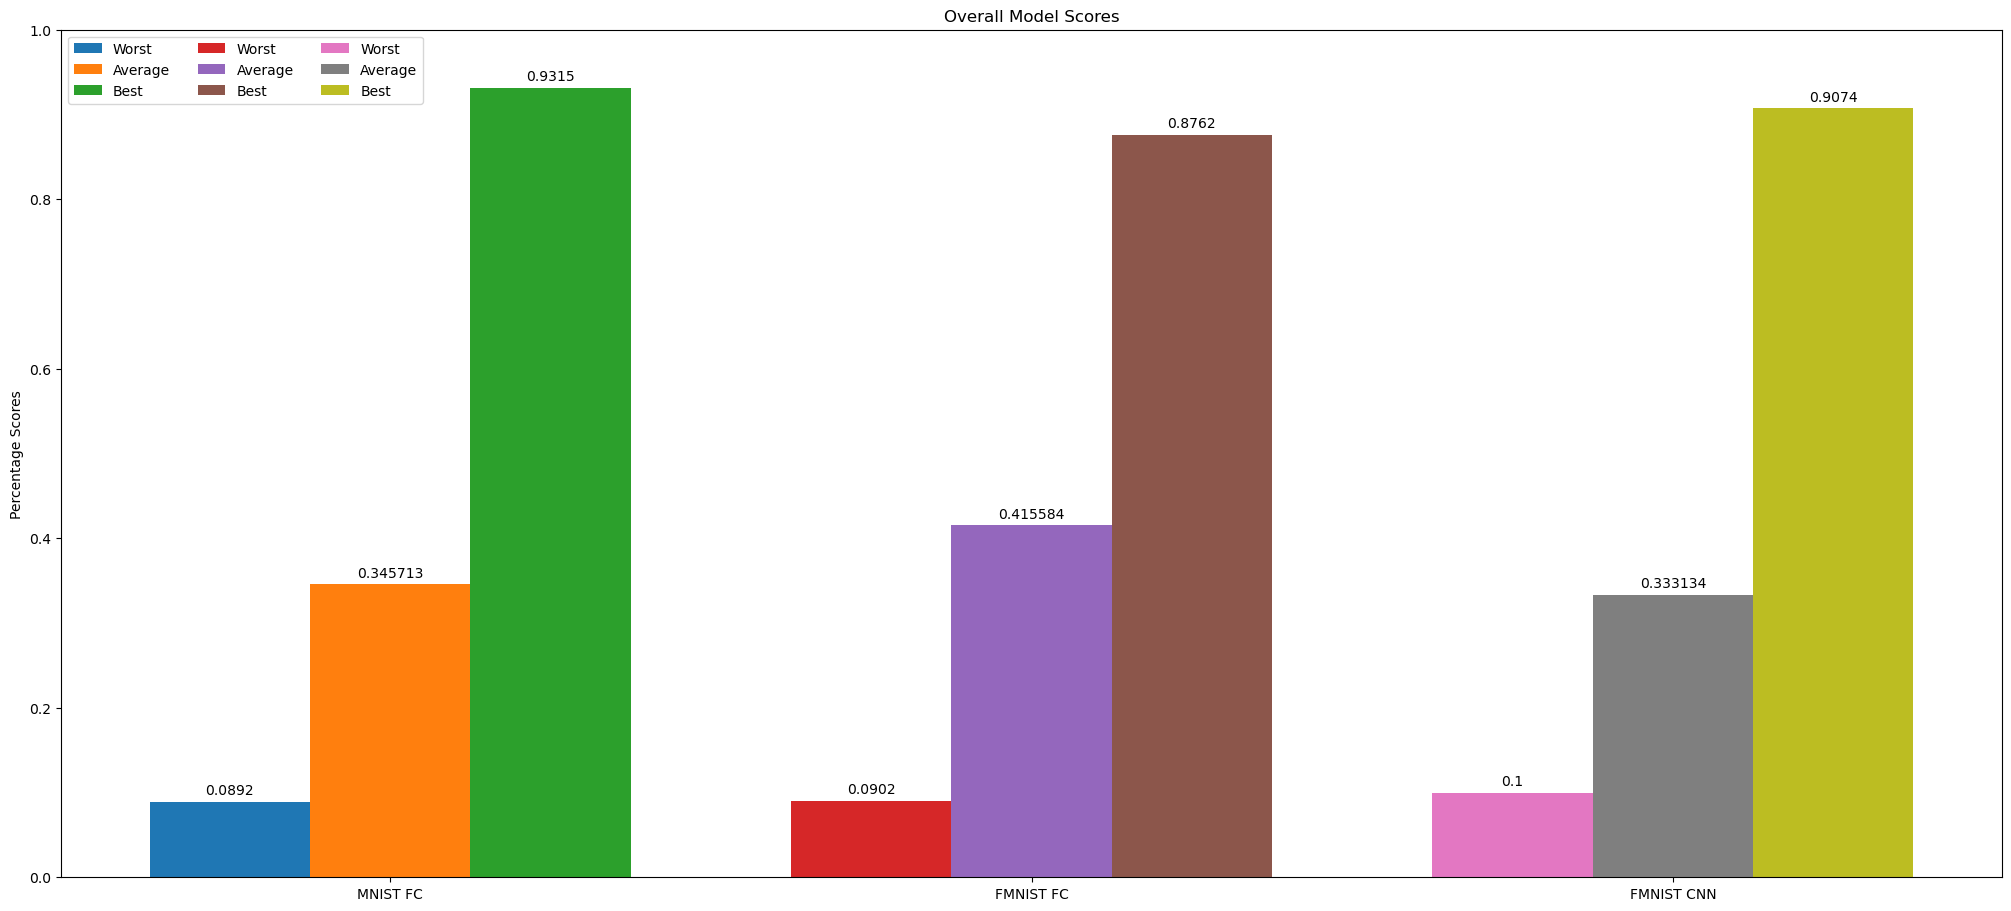

In [11]:
x = np.arange(len(overall_scores.keys()))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20,9),layout='constrained')

for model in overall_scores:
    for performance, score in overall_scores[model].items():
        offset = width * multiplier
        rects = ax.bar(offset, score, width, label=performance)
        ax.bar_label(rects, padding=3)
        multiplier += 1  
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage Scores')
ax.set_title(f'Overall Model Scores')
ax.set_xticks(x + width, overall_scores.keys())
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

In [9]:
mnist_fc_complexity_by_scores = mnist_fixed_fc_df.groupby('number_of_layers')['score'].mean()
fmnist_fc_complexity_by_scores = fmnist_fixed_fc_df.groupby('number_of_layers')['score'].mean()
fmnist_cnn_complexity_by_scores = fmnist_fixed_cnn_df.groupby('conv2d_layers')['accuracy'].mean()
complexity_scores = {'MNIST FC':mnist_fc_complexity_by_scores,'FMNIST FC':fmnist_fc_complexity_by_scores,'FMNIST CNN':fmnist_cnn_complexity_by_scores}

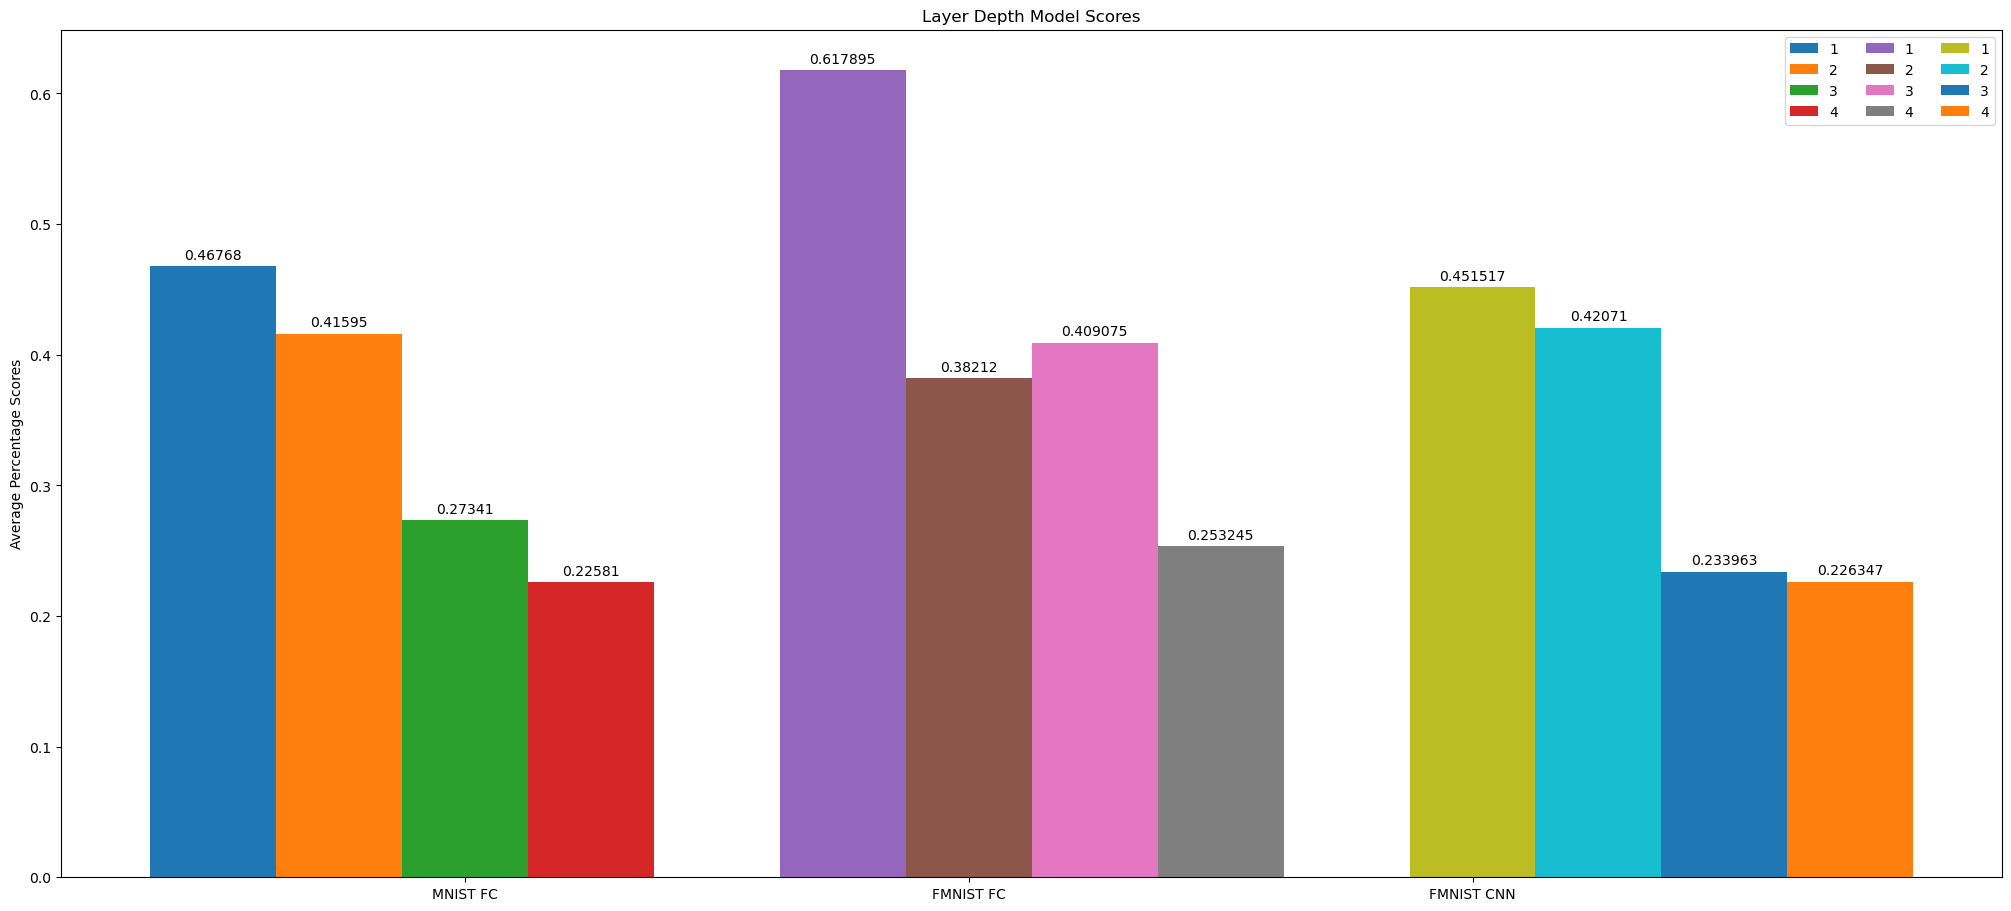

In [10]:
x = np.arange(len(complexity_scores.keys()))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20,9),layout='constrained')

for model in complexity_scores:
    for performance, score in complexity_scores[model].items():
        offset = width * multiplier
        rects = ax.bar(offset, score, width, label=performance)
        ax.bar_label(rects, padding=3)
        multiplier += 1  
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Percentage Scores')
ax.set_title(f'Layer Depth Model Scores')
ax.set_xticks(x + width+0.25, complexity_scores.keys())
ax.legend(loc='upper right', ncols=3)

plt.show()

In [12]:
mnist_fc_width_by_scores = mnist_fixed_fc_df.groupby(['number_of_layers',mnist_fixed_fc_df['neurons_per_layer'].map(tuple)])['score'].mean()
fmnist_fc_width_by_scores = fmnist_fixed_fc_df.groupby(['number_of_layers',fmnist_fixed_fc_df['neurons_per_layer'].map(tuple)])['score'].mean()
fmnist_cnn_width_by_scores = fmnist_fixed_cnn_df.groupby(['conv2d_layers',fmnist_fixed_cnn_df['conv2d_outputs'].map(tuple)])['accuracy'].mean()
width_scores = {'MNIST FC':mnist_fc_width_by_scores,'FMNIST FC':fmnist_fc_width_by_scores,'FMNIST CNN':fmnist_cnn_width_by_scores}

In [13]:
mnist_fc_width_by_scores

number_of_layers  neurons_per_layer   
1                 (10, 10)                0.49695
                  (20, 10)                0.45270
                  (30, 10)                0.91870
                  (40, 10)                0.15855
                  (50, 10)                0.31150
2                 (30, 10, 10)            0.51400
                  (30, 20, 10)            0.44450
                  (30, 30, 10)            0.49970
                  (30, 40, 10)            0.10835
                  (30, 50, 10)            0.51320
3                 (30, 10, 10, 10)        0.23460
                  (30, 10, 20, 10)        0.23850
                  (30, 10, 30, 10)        0.10575
                  (30, 10, 40, 10)        0.68100
                  (30, 10, 50, 10)        0.10720
4                 (30, 10, 10, 10, 10)    0.68020
                  (30, 10, 10, 20, 10)    0.11350
                  (30, 10, 10, 30, 10)    0.11350
                  (30, 10, 10, 40, 10)    0.10835
           

In [14]:
fmnist_fc_width_by_scores

number_of_layers  neurons_per_layer   
1                 (10, 10)                0.496375
                  (20, 10)                0.642175
                  (30, 10)                0.722475
                  (40, 10)                0.664500
                  (50, 10)                0.563950
2                 (40, 10, 10)            0.254775
                  (40, 20, 10)            0.447050
                  (40, 30, 10)            0.312375
                  (40, 40, 10)            0.623675
                  (40, 50, 10)            0.272725
3                 (40, 10, 10, 10)        0.468875
                  (40, 10, 20, 10)        0.588550
                  (40, 10, 30, 10)        0.293400
                  (40, 10, 40, 10)        0.258775
                  (40, 10, 50, 10)        0.435775
4                 (40, 10, 10, 10, 10)    0.253225
                  (40, 10, 10, 20, 10)    0.348050
                  (40, 10, 10, 30, 10)    0.464950
                  (40, 10, 10, 40, 10)    0

In [15]:
fmnist_cnn_width_by_scores

conv2d_layers  conv2d_outputs    
1              (32,)                 0.49282
               (64,)                 0.40767
               (128,)                0.45406
2              (32, 32)              0.39972
               (32, 64)              0.47735
               (32, 128)             0.38506
3              (32, 32, 32)          0.21787
               (32, 32, 64)          0.22551
               (32, 32, 128)         0.25851
4              (32, 32, 128, 32)     0.28550
               (32, 32, 128, 64)     0.24889
               (32, 32, 128, 128)    0.14465
Name: accuracy, dtype: float64

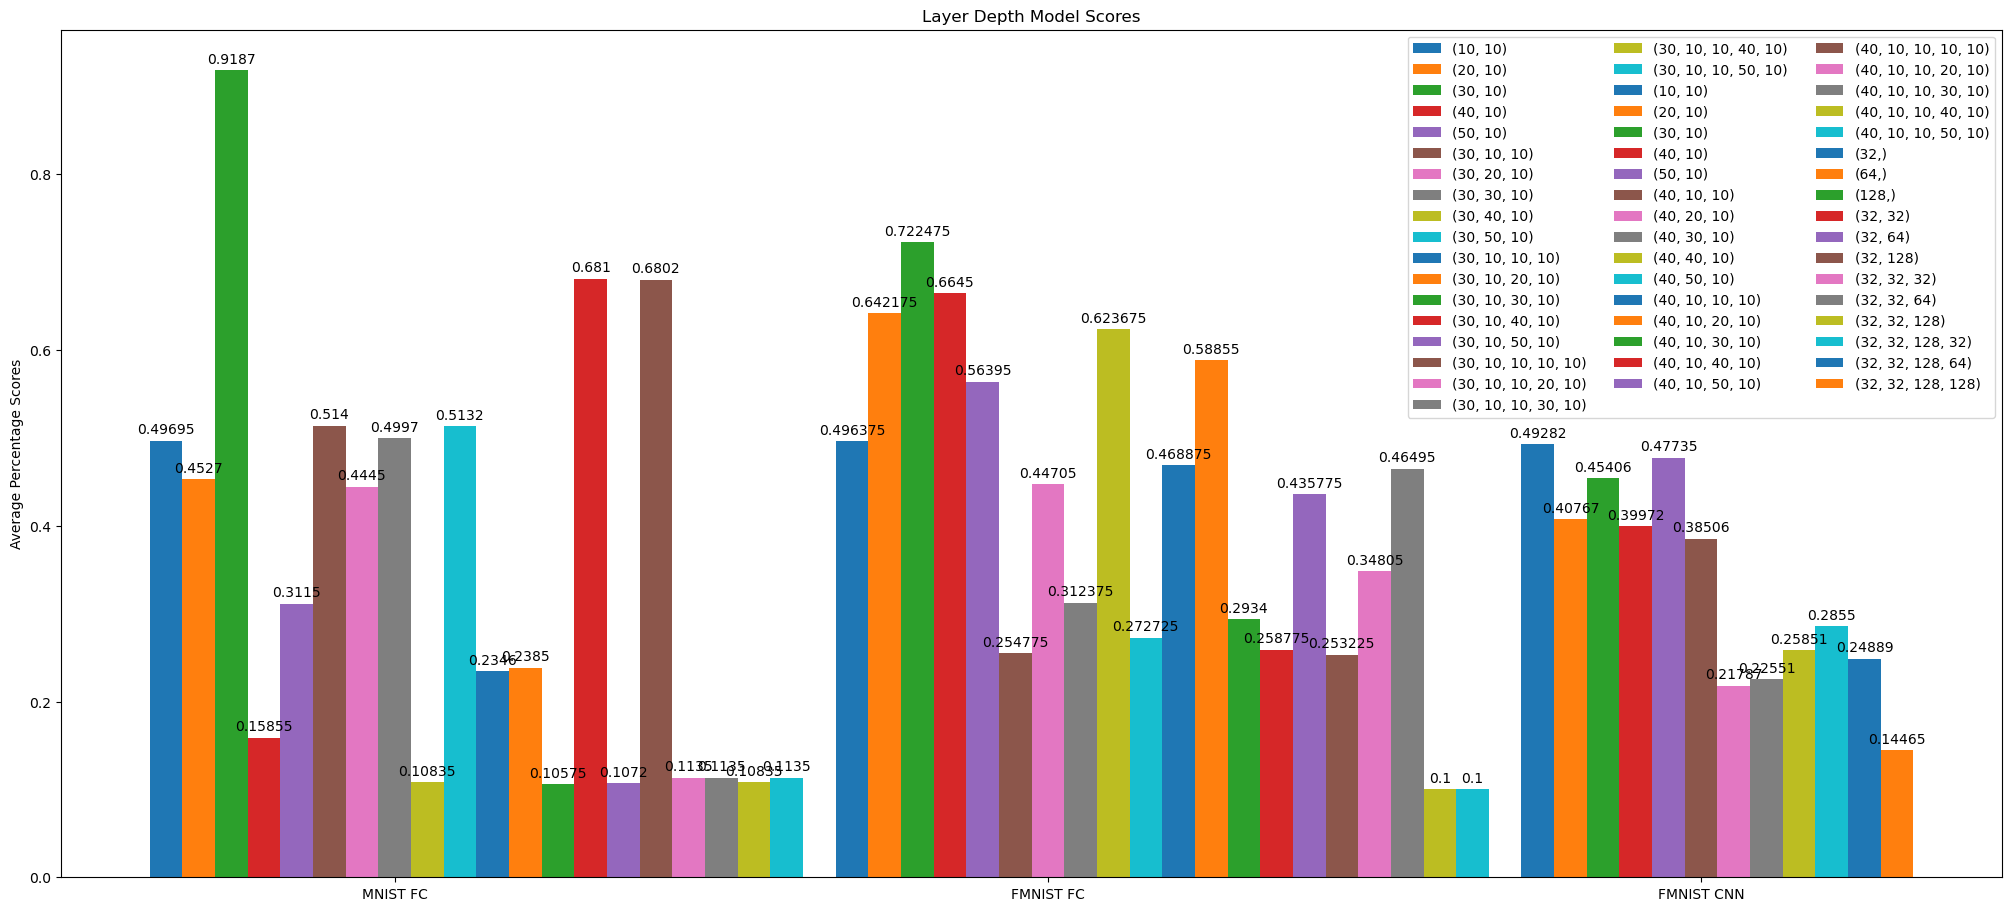

In [16]:
x = np.arange(len(width_scores.keys()))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20,9),layout='constrained')

for model in complexity_scores:
    for performance in width_scores[model].index:
        offset = width * multiplier
        rects = ax.bar(offset, width_scores[model][performance], width, label=f'{performance[1]}')
        ax.bar_label(rects, padding=3)
        multiplier += 1  
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Percentage Scores')
ax.set_title(f'Layer Depth Model Scores')
ax.set_xticks((x+width)*5 + width+0.25, width_scores.keys())
ax.legend(loc='upper right', ncols=3)

plt.show()

Disregard the x-ticks and you get the idea. While the result is hideous and the average scores are pretty bad all around (due to the random sampling of most hyperparameters), there is still a relatively significant trend that networks with less layers and less neurons _generally_ perform slightly better.

In [17]:
mnist_fc_width_by_optimizer = mnist_fixed_fc_df.groupby(['optimizers'])['score'].mean()
fmnist_fc_width_by_optimizer = fmnist_fixed_fc_df.groupby(['optimizers'])['score'].mean()
fmnist_cnn_width_by_optimizer = fmnist_fixed_cnn_df.groupby(['optimizers'])['accuracy'].mean()
optimizer_scores = {'MNIST FC':mnist_fc_width_by_optimizer,'FMNIST FC':fmnist_fc_width_by_optimizer,'FMNIST CNN':fmnist_cnn_width_by_optimizer}

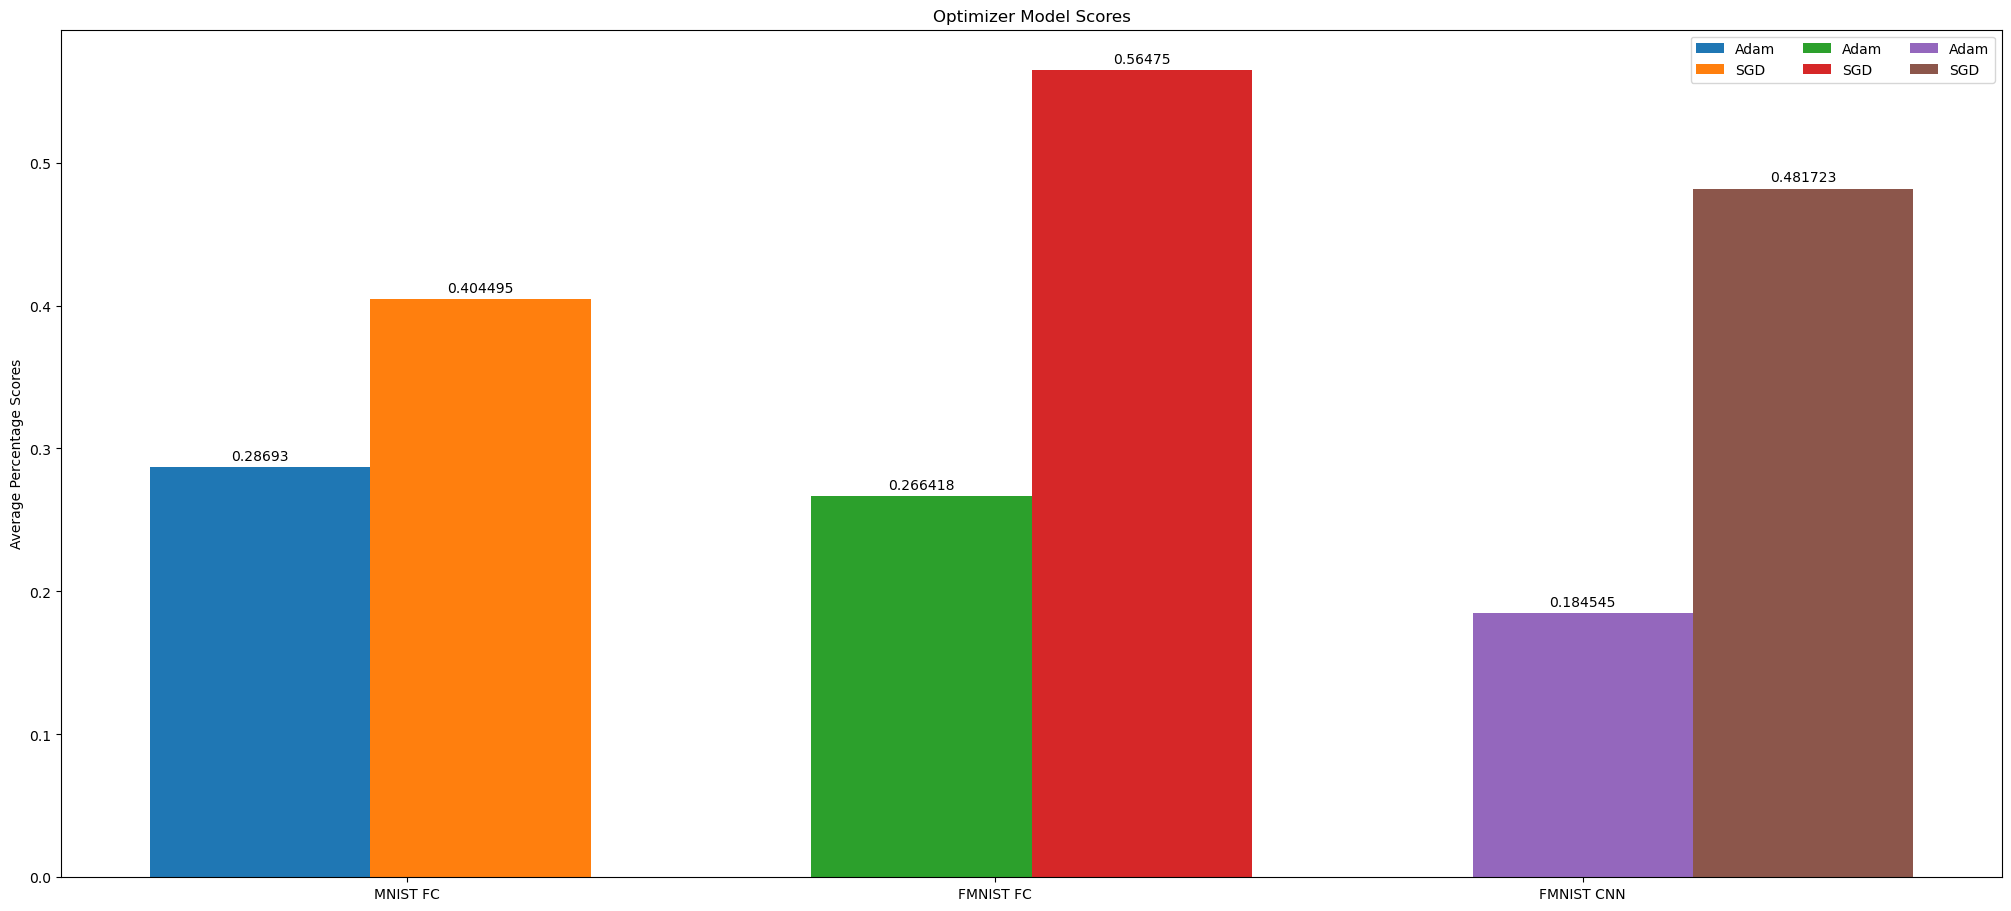

In [18]:
x = np.arange(len(optimizer_scores.keys()))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20,9),layout='constrained')

for model in optimizer_scores:
    for performance, score in optimizer_scores[model].items():
        offset = width * multiplier
        rects = ax.bar(offset, score, width, label=performance)
        ax.bar_label(rects, padding=3)
        multiplier += 1  
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Percentage Scores')
ax.set_title(f'Optimizer Model Scores')
ax.set_xticks((x+width)/1.5, optimizer_scores.keys())
ax.legend(loc='upper right', ncols=3)

plt.show()

In [19]:
mnist_fc_width_by_batch = mnist_fixed_fc_df.groupby(['batches'])['score'].mean()
fmnist_fc_width_by_batch = fmnist_fixed_fc_df.groupby(['batches'])['score'].mean()
fmnist_cnn_width_by_batch = fmnist_fixed_cnn_df.groupby(['batches'])['accuracy'].mean()
batch_scores = {'MNIST FC':mnist_fc_width_by_batch,'FMNIST FC':fmnist_fc_width_by_batch,'FMNIST CNN':fmnist_cnn_width_by_batch}

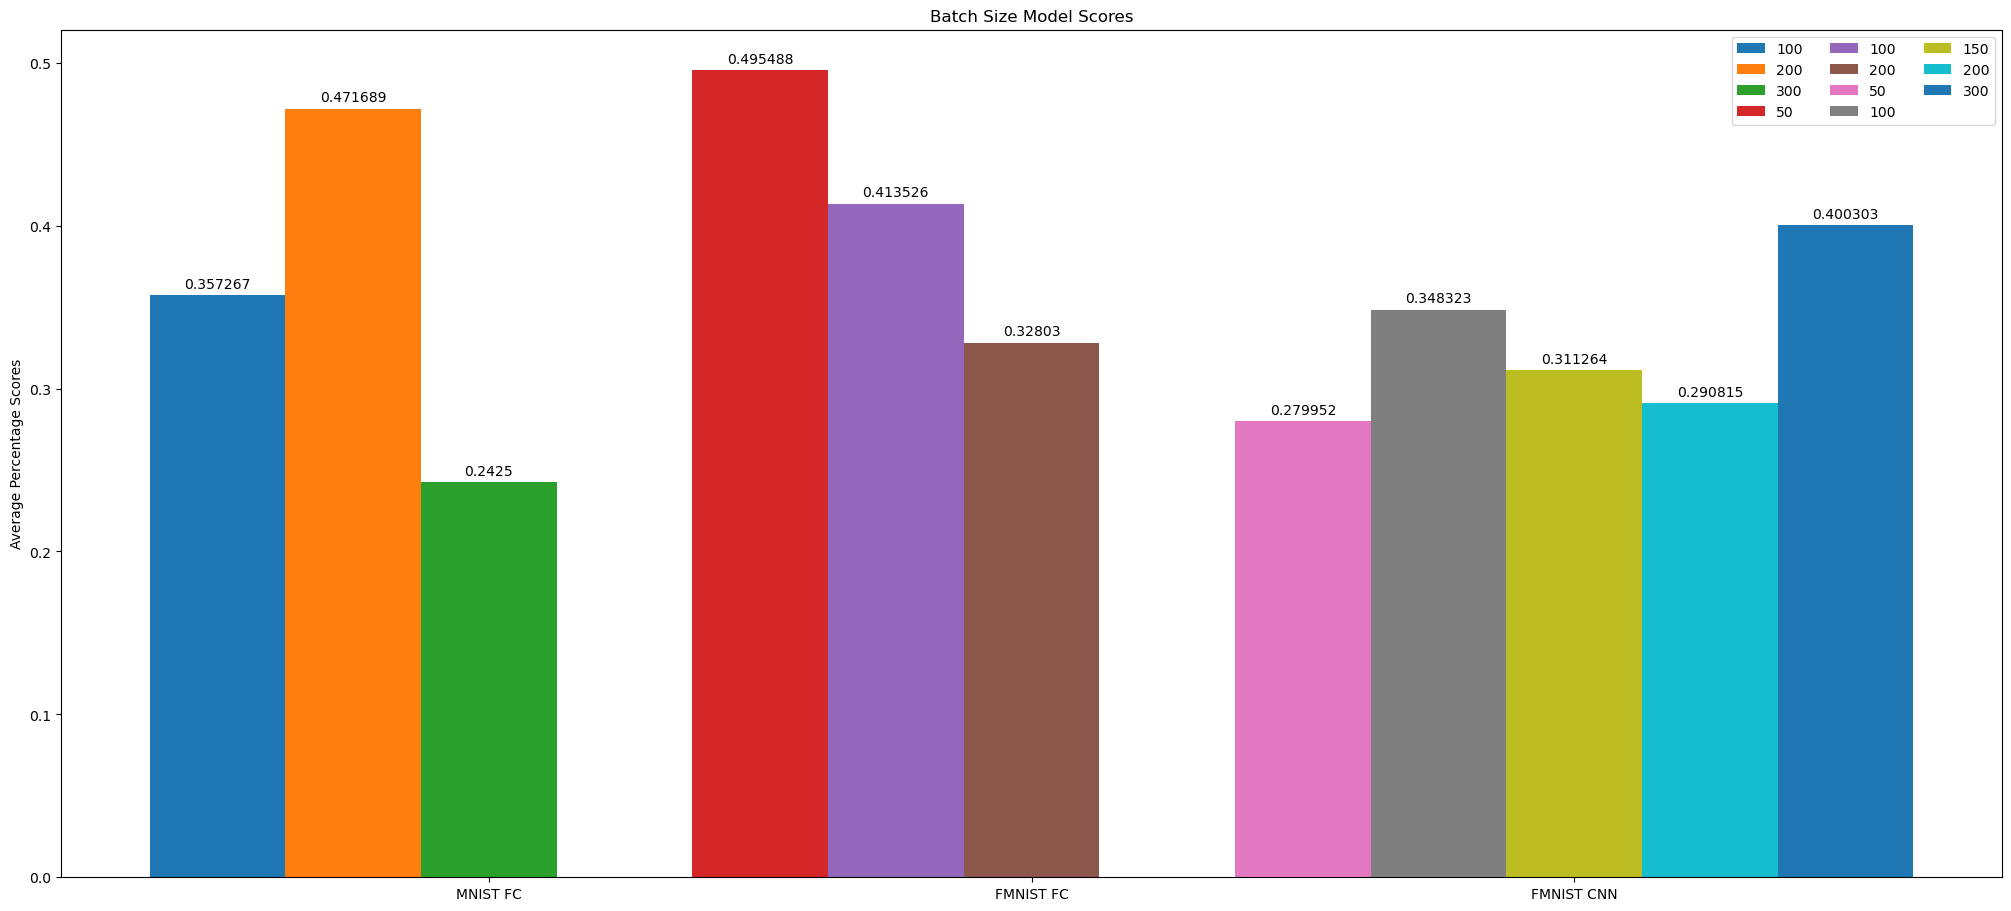

In [20]:
x = np.arange(len(batch_scores.keys()))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20,9),layout='constrained')

for model in batch_scores:
    for performance, score in batch_scores[model].items():
        offset = width * multiplier
        rects = ax.bar(offset, score, width, label=performance)
        ax.bar_label(rects, padding=3)
        multiplier += 1  
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Percentage Scores')
ax.set_title(f'Batch Size Model Scores')
ax.set_xticks(x + width+0.25, batch_scores.keys())
ax.legend(loc='upper right', ncols=3)

plt.show()

Finally, let's make some tables for the report.

In [21]:
mnist_fc_min = mnist_fixed_fc_df.sort_values(by='score').T
fmnist_fc_min = fmnist_fixed_fc_df.sort_values(by='score').T
fmnist_cnn_min = fmnist_fixed_cnn_df.sort_values(by='accuracy').T

In [22]:
mnist_fc_min

,2,14,12,0,24,28,9,22,10,37,...,13,3,18,30,1,26,5,15,11,4
inputs,784,784,784,784,784,784,784,784,784,784,...,784,784,784,784,784,784,784,784,784,784
number_of_layers,1,2,2,1,3,3,1,3,2,4,...,2,1,2,4,1,3,1,2,2,1
outputs,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
neurons_per_layer,"[20, 10]","[30, 30, 10]","[30, 20, 10]","[10, 10]","[30, 10, 30, 10]","[30, 10, 50, 10]","[50, 10]","[30, 10, 20, 10]","[30, 10, 10]","[30, 10, 10, 40, 10]",...,"[30, 20, 10]","[20, 10]","[30, 50, 10]","[30, 10, 10, 10, 10]","[10, 10]","[30, 10, 40, 10]","[30, 10]","[30, 30, 10]","[30, 10, 10]","[30, 10]"
dropout_layers,False,True,False,False,False,True,True,False,False,True,...,True,True,True,True,False,False,True,False,True,False
activation_functions,[sigmoid],"[tanh, sigmoid]","[tanh, relu]",[sigmoid],"[tanh, sigmoid, tanh]","[tanh, sigmoid, relu]",[relu],"[tanh, sigmoid, tanh]","[tanh, relu]","[tanh, sigmoid, relu, sigmoid]",...,"[tanh, sigmoid]",[relu],"[tanh, sigmoid]","[tanh, sigmoid, relu, relu]",[relu],"[tanh, sigmoid, relu]",[sigmoid],"[tanh, sigmoid]","[tanh, relu]",[tanh]
optimizers,Adam,Adam,Adam,Adam,Adam,Adam,SGD,Adam,Adam,SGD,...,SGD,SGD,Adam,Adam,SGD,Adam,SGD,SGD,SGD,Adam
learning_rates,0.3,0.1,0.1,0.3,0.1,0.1,0.3,0.01,0.03,0.3,...,0.03,0.003,0.01,0.001,0.001,0.003,0.01,0.03,0.003,0.001
weight_decays,1.0,0.3,0.1,1.0,1.0,0.03,0.1,0.03,0.3,1.0,...,0.03,0.3,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01
loss_functions,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,...,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss


In [23]:
fmnist_fc_min

,28,22,79,78,40,24,42,46,20,48,...,9,1,29,19,47,43,11,65,49,15
inputs,784,784,784,784,784,784,784,784,784,784,...,784,784,784,784,784,784,784,784,784,784
number_of_layers,2,2,4,4,3,2,3,3,2,3,...,1,1,2,1,3,3,1,4,3,1
outputs,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
neurons_per_layer,"[40, 30, 10]","[40, 10, 10]","[40, 10, 10, 50, 10]","[40, 10, 10, 50, 10]","[40, 10, 10, 10]","[40, 20, 10]","[40, 10, 10, 10]","[40, 10, 20, 10]","[40, 10, 10]","[40, 10, 30, 10]",...,"[30, 10]","[10, 10]","[40, 30, 10]","[50, 10]","[40, 10, 20, 10]","[40, 10, 10, 10]","[30, 10]","[40, 10, 10, 20, 10]","[40, 10, 30, 10]","[40, 10]"
dropout_layers,True,False,False,False,False,True,True,False,False,False,...,False,True,False,True,True,False,False,False,False,True
activation_functions,"[relu, tanh]","[relu, relu]","[relu, sigmoid, relu, tanh]","[relu, sigmoid, relu, tanh]","[relu, sigmoid, sigmoid]","[relu, tanh]","[relu, sigmoid, tanh]","[relu, sigmoid, tanh]","[relu, sigmoid]","[relu, sigmoid, sigmoid]",...,[relu],[tanh],"[relu, tanh]",[relu],"[relu, sigmoid, sigmoid]","[relu, sigmoid, tanh]",[sigmoid],"[relu, sigmoid, relu, tanh]","[relu, sigmoid, sigmoid]",[relu]
optimizers,Adam,Adam,SGD,Adam,Adam,Adam,Adam,Adam,Adam,Adam,...,SGD,SGD,SGD,SGD,SGD,SGD,SGD,SGD,SGD,SGD
learning_rates,0.3,0.3,0.3,0.1,0.3,0.3,0.3,0.01,0.1,0.01,...,0.01,0.01,0.03,0.3,0.03,0.03,0.03,0.3,0.1,0.03
weight_decays,0.01,0.1,0.1,0.1,0.01,0.1,0.03,0.3,0.3,0.03,...,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
loss_functions,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,...,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss,CrossEntropyLoss


In [24]:
fmnist_cnn_min

,51,72,71,70,67,66,65,64,63,73,...,29,25,24,47,45,99,0,1,69,86
network_inputs,"(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)",...,"(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)"
conv2d_layers,2,3,3,3,3,3,3,3,3,3,...,1,1,1,2,2,4,1,1,3,3
conv2d_outputs,"[32, 128]","[32, 32, 64]","[32, 32, 64]","[32, 32, 64]","[32, 32, 32]","[32, 32, 32]","[32, 32, 32]","[32, 32, 32]","[32, 32, 32]","[32, 32, 64]",...,[128],[128],[128],"[32, 64]","[32, 64]","[32, 32, 128, 32]",[32],[32],"[32, 32, 32]","[32, 32, 128]"
kernels,"[(2, 2), (3, 3)]","[(2, 2), (2, 2), (4, 4)]","[(2, 2), (2, 2), (5, 5)]","[(2, 2), (2, 2), (3, 3)]","[(2, 2), (2, 2), (4, 4)]","[(2, 2), (2, 2), (4, 4)]","[(2, 2), (2, 2), (3, 3)]","[(2, 2), (2, 2), (4, 4)]","[(2, 2), (2, 2), (2, 2)]","[(2, 2), (2, 2), (5, 5)]",...,"[(2, 2)]","[(5, 5)]","[(4, 4)]","[(2, 2), (5, 5)]","[(2, 2), (4, 4)]","[(2, 2), (2, 2), (2, 2), (4, 4)]","[(2, 2)]","[(2, 2), (2, 2), (5, 5)]","[(2, 2), (2, 2), (3, 3)]","[(2, 2), (2, 2), (2, 2)]"
dense_layers,2,1,3,1,3,3,3,3,2,3,...,2,2,3,3,2,2,1,1,2,2
dense_outputs,"[64, 64, 10]","[32, 10]","[128, 16, 32, 10]","[64, 10]","[128, 64, 128, 10]","[128, 32, 64, 10]","[16, 16, 32, 10]","[64, 128, 16, 10]","[128, 32, 10]","[128, 32, 128, 10]",...,"[32, 64, 10]","[32, 64, 10]","[32, 64, 64, 10]","[128, 128, 32, 10]","[64, 128, 10]","[64, 128, 10]","[128, 10]","[32, 10]","[16, 32, 10]","[16, 32, 10]"
network_output,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
dropout_layers,True,False,False,True,True,True,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
conv2d_activations,"[relu, tanh]","[relu, sigmoid, tanh]","[relu, sigmoid, sigmoid]","[relu, sigmoid, tanh]","[relu, sigmoid, relu]","[relu, sigmoid, tanh]","[relu, sigmoid, tanh]","[relu, sigmoid, sigmoid]","[relu, sigmoid, tanh]","[relu, sigmoid, relu]",...,[relu],[relu],[relu],"[relu, relu]","[relu, sigmoid]","[relu, sigmoid, relu, relu]",[relu],[relu],"[relu, sigmoid, relu]","[relu, sigmoid, relu]"
dense_activations,"[tanh, relu, softmax]","[sigmoid, softmax]","[relu, tanh, sigmoid, softmax]","[sigmoid, softmax]","[tanh, sigmoid, tanh, softmax]","[relu, relu, tanh, softmax]","[tanh, sigmoid, tanh, softmax]","[tanh, relu, sigmoid, softmax]","[relu, sigmoid, softmax]","[sigmoid, relu, sigmoid, softmax]",...,"[tanh, tanh, softmax]","[sigmoid, relu, softmax]","[sigmoid, relu, sigmoid, softmax]","[tanh, sigmoid, tanh, softmax]","[sigmoid, tanh, softmax]","[relu, sigmoid, softmax]","[relu, softmax]","[tanh, softmax]","[sigmoid, tanh, softmax]","[tanh, sigmoid, softmax]"
